In [1200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import statsmodels.api as sm
import datetime
import re
import QuantLib as ql
import copy
import pickle

from datetime import datetime

from filterpy.kalman import KalmanFilter

from matplotlib.ticker import LinearLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy import optimize
from scipy.optimize import root
from scipy.optimize import fsolve
from scipy import interpolate
from scipy.stats import norm

from functools import reduce

from pykalman import KalmanFilter

In [1049]:
def pickle_dict(filename, dic=None, serialize='wb'):
    if serialize == 'wb':
        with open(f'{filename}.pickle', serialize) as handle:
            pickle.dump(dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(f'{filename}.pickle', serialize) as handle:
            return pickle.load(handle)

# EDA

## Import Data

In [116]:
vol_tickers = pd.read_excel('SOFR_data.xlsx', sheet_name=1).iloc[:-5, :]
curve_tickers = pd.read_excel('SOFR_data.xlsx', sheet_name=2).iloc[:-7, :]
curve = pd.read_excel('SOFR_data.xlsx', sheet_name='S490')
prices = pd.read_excel('SOFR_data.xlsx', sheet_name=3, skiprows=18, index_col=0).iloc[:10, 1:28]

vol_tickers.index = [val[:-1] for val in vol_tickers['Expiry']]
vol_tickers.drop(['Expiry'], axis=1, inplace=True)

## Analyze Vol

In [117]:
def parse_vol(vol_surface):
    max_len = 0
    max_col = 0

    for col in vol_surface.iloc[:, 2::2].columns:
        cur_len = len(vol_surface.iloc[:, 2::2][col].dropna())
        if cur_len > max_len:
            max_len = cur_len
            max_col = col
        else:
            continue

    vol_df = pd.DataFrame(vol_surface[max_col].dropna().values, 
                         columns=['Dates'])

    for j in range(len(vol_surface.columns)//2-2):
        try:    
            vol_df = vol_df.merge(vol_surface.iloc[1:, 2+j*2:2+(j+1)*2].set_index('Unnamed: {}'.format(2+j*2)), 
                              left_on='Dates', right_index=True, how='left').fillna(method='bfill')
        except ValueError:
            pass

    vol_df.set_index('Dates', inplace=True)
    
    return vol_df

Create stable panel of data for volatility surfaces

In [118]:
tenors = vol_tickers.index
vol_dict = {tenor : pd.DataFrame for tenor in tenors}

for tenor in vol_dict.keys():
    vol_surface = pd.read_excel('SOFR_data.xlsx', sheet_name=tenor)
    vol_dict[tenor] = parse_vol(vol_surface)

Let's see the example

In [119]:
vol_dict['1Y'].head()

,USCLQD1,USCLQC1,USCLQB1,USCNSQ1,USCNQA1,USCNQB1,USCNQC1,USCNQD1,USCNQE1,USCNQG1,USCNQH1,USCNQI1,USCNQJ1,USCNQK1,USCNQL1,USCNQM1,USCNQO1,USCNQQ1
Dates,,,,,,,,,,,,,,,,,,
2022-09-27,133.9,134.2,114.3,127.0,112.3,109.9,107.4,104.8,102.7,101.5,103.3,103.8,103.8,112.1,122.8,133.1,143.1,162.4
2022-09-26,133.9,118.3,117.9,120.8,115.9,113.6,111.1,108.5,105.8,101.3,99.7,99.0,98.3,106.1,115.3,124.0,133.2,151.6
2022-09-23,133.9,118.3,119.2,113.1,117.2,114.9,112.3,109.6,106.8,101.3,97.1,94.4,93.4,101.0,108.6,116.1,124.6,142.7
2022-09-22,133.9,118.3,119.3,91.2,117.2,114.8,112.1,109.4,106.5,100.7,95.0,89.1,85.6,89.6,90.1,93.3,100.3,120.7
2022-09-21,133.9,118.3,118.0,91.0,115.8,113.4,110.7,107.8,104.8,98.9,93.1,87.5,84.5,88.6,89.7,93.8,101.4,122.8


## Analyze Curve

Create stable panel of data for interest rate swaps

In [120]:
def parse_curve(curve):
    max_len = 0
    max_col = 0

    for col in curve.iloc[:, 0::2].columns:
        cur_len = len(curve.iloc[:, 0::2][col].dropna())
        if cur_len > max_len:
            max_len = cur_len
            max_col = col
        else:
            continue
    curve_df = pd.DataFrame(curve[max_col].values, 
                     columns=['Dates'])

    for j in range(len(curve.columns)//2):
        curve_df = curve_df.merge(curve.iloc[:, j*2:(j+1)*2].set_index('Unnamed: {}'.format(j*2)), 
                      left_on='Dates', right_index=True, how='left').fillna(method='bfill')

    curve_df.set_index('Dates', inplace=True)
    
    return curve_df

In [123]:
s_490 = parse_curve(curve).iloc[:, :-7]

In [124]:
s_490.head()

,SOFRRATE Index,USOSFR1Z BGN Curncy,USOSFR2Z BGN Curncy,USOSFR3Z BGN Curncy,USOSFRA BGN Curncy,USOSFRB BGN Curncy,USOSFRC BGN Curncy,USOSFRD BGN Curncy,USOSFRE BGN Curncy,USOSFRF BGN Curncy,...,USOSFR1 BGN Curncy,USOSFR2 BGN Curncy,USOSFR3 BGN Curncy,USOSFR4 BGN Curncy,USOSFR5 BGN Curncy,USOSFR6 BGN Curncy,USOSFR7 BGN Curncy,USOSFR8 BGN Curncy,USOSFR9 BGN Curncy,USOSFR10 BGN Curncy
Dates,,,,,,,,,,,,,,,,,,,,,
2022-09-27,2.99,3.0281,3.0265,3.0285,3.0320,3.3190,3.5226,3.6970,3.8375,3.9435,...,4.2762,4.2800,4.1200,3.9945,3.9039,3.8288,3.7652,3.7131,3.6734,3.6434
2022-09-26,2.99,3.0407,3.0415,3.0425,3.0438,3.3331,3.5466,3.7400,3.8900,3.9990,...,4.3870,4.3895,4.2065,4.0640,3.9571,3.8692,3.7959,3.7368,3.6917,3.6579
2022-09-23,2.99,3.0304,3.0250,3.0322,3.0367,3.3235,3.5270,3.7125,3.8735,3.9850,...,4.3807,4.3292,4.0955,3.9093,3.7735,3.6701,3.5893,3.5278,3.4818,3.4507
2022-09-22,2.99,3.0301,3.0310,3.0315,3.0320,3.3152,3.5175,3.6963,3.8575,3.9690,...,4.3482,4.2571,4.0185,3.8514,3.7408,3.6570,3.5923,3.5425,3.5059,3.4827
2022-09-21,2.25,3.0351,3.0370,3.0369,3.0387,3.2689,3.4711,3.6697,3.8229,3.9326,...,4.2960,4.1874,3.9302,3.7256,3.5849,3.4928,3.4245,3.3726,3.3379,3.3164


## Merge the dates between Vols and Rates

In [125]:
for tenor in vol_dict.keys():
    index_intersection = set(s_490.index).intersection(vol_dict[tenor].index)
    vol_dict[tenor] = vol_dict[tenor].loc[index_intersection, :].sort_index(ascending=False)

In [1076]:
# Save data to reuse it
# pickle_dict('vol_dict', vol_dict)
vol_dict = pickle_dict('vol_dict', serialize='rb')

## Create Auxillary Data

In [126]:
for i in range(len(curve_tickers)):
    
    tenor = curve_tickers.Tenor[i]
    
    if len(tenor) == 2:
        tenor_numeric = int(tenor[0])
    elif len(tenor) == 3:
        tenor_numeric = int(tenor[:2])

    if 'D' in tenor:
        curve_tickers.loc[i, 'year_frac'] = tenor_numeric / 360
    elif 'W' in tenor:
        curve_tickers.loc[i, 'year_frac'] = tenor_numeric * 7 / 360
    elif 'M' in tenor:
        curve_tickers.loc[i, 'year_frac'] = tenor_numeric * 30 / 360
    else:
        if tenor_numeric <= 10:
            curve_tickers.loc[i, 'year_frac'] = tenor_numeric

Create mapping for ticker to year fraction:

In [127]:
ticker_yearfrac_dict = curve_tickers[['Cusip', 'year_frac']].set_index('Cusip').to_dict()['year_frac']

In [1075]:
# Save data to reuse it
# pickle_dict('ticker_yearfrac_dict', ticker_yearfrac_dict)
ticker_yearfrac_dict = pickle_dict('ticker_yearfrac_dict', serialize='rb')

Create mapping for tenor and strike to ticker:

In [128]:
ticker_strike_dict = {}
ticker_strike_dict_unique = {}
strikes_unique = []
pattern = r'[0-9]'

for tenor in vol_tickers.index:
    for strike in vol_tickers.columns:
        strike_generic = re.sub(pattern, '', vol_tickers.loc[tenor, strike]).replace(' ', '')
        ticker_strike_dict[(tenor, strike)] = vol_tickers.loc[tenor, strike]
        strikes_unique.append(strike_generic)
        ticker_strike_dict_unique[strike_generic] = strike

strikes_unique = set(strikes_unique)

In [129]:
strikes_unique_keep = []

for strike in strikes_unique:
    count = 0
    for key in vol_dict:
        if strike+key[:-1] in vol_dict[key].columns:
            count += 1
        if count == len(vol_dict.keys()):
            strikes_unique_keep.append(strike)
strikes_unique_keep = set(strikes_unique_keep)

In [130]:
vol_tickers

,-2.00%,-1.50%,-1.25%,-1.00%,-0.75%,-0.50%,-0.25%,-0.10%,ATM,0.00%,...,2.50%,3.00%,3.50%,4.00%,4.50%,5.00%,5.50%,6.00%,6.50%,7.00%
1Y,USCLQH1,USCLQG1,USCLQF1,USCLQE1,USCLQD1,USCLQC1,USCLQB1,USCLQA1,USCNSQ1,USCNQA1,...,USCNQI1,USCNQJ1,USCNQK1,USCNQL1,USCNQM1,USCNQO1,USCNQP1,USCNQQ1,USCNQR1,USCNQS1
2Y,USCLQH2,USCLQG2,USCLQF2,USCLQE2,USCLQD2,USCLQC2,USCLQB2,USCLQA2,USCNSQ2,USCNQA2,...,USCNQI2,USCNQJ2,USCNQK2,USCNQL2,USCNQM2,USCNQO2,USCNQP2,USCNQQ2,USCNQR2,USCNQS2
3Y,USCLQH3,USCLQG3,USCLQF3,USCLQE3,USCLQD3,USCLQC3,USCLQB3,USCLQA3,USCNSQ3,USCNQA3,...,USCNQI3,USCNQJ3,USCNQK3,USCNQL3,USCNQM3,USCNQO3,USCNQP3,USCNQQ3,USCNQR3,USCNQS3
4Y,USCLQH4,USCLQG4,USCLQF4,USCLQE4,USCLQD4,USCLQC4,USCLQB4,USCLQA4,USCNSQ4,USCNQA4,...,USCNQI4,USCNQJ4,USCNQK4,USCNQL4,USCNQM4,USCNQO4,USCNQP4,USCNQQ4,USCNQR4,USCNQS4
5Y,USCLQH5,USCLQG5,USCLQF5,USCLQE5,USCLQD5,USCLQC5,USCLQB5,USCLQA5,USCNSQ5,USCNQA5,...,USCNQI5,USCNQJ5,USCNQK5,USCNQL5,USCNQM5,USCNQO5,USCNQP5,USCNQQ5,USCNQR5,USCNQS5
6Y,USCLQH6,USCLQG6,USCLQF6,USCLQE6,USCLQD6,USCLQC6,USCLQB6,USCLQA6,USCNSQ6,USCNQA6,...,USCNQI6,USCNQJ6,USCNQK6,USCNQL6,USCNQM6,USCNQO6,USCNQP6,USCNQQ6,USCNQR6,USCNQS6
7Y,USCLQH7,USCLQG7,USCLQF7,USCLQE7,USCLQD7,USCLQC7,USCLQB7,USCLQA7,USCNSQ7,USCNQA7,...,USCNQI7,USCNQJ7,USCNQK7,USCNQL7,USCNQM7,USCNQO7,USCNQP7,USCNQQ7,USCNQR7,USCNQS7
8Y,USCLQH8,USCLQG8,USCLQF8,USCLQE8,USCLQD8,USCLQC8,USCLQB8,USCLQA8,USCNSQ8,USCNQA8,...,USCNQI8,USCNQJ8,USCNQK8,USCNQL8,USCNQM8,USCNQO8,USCNQP8,USCNQQ8,USCNQR8,USCNQS8
9Y,USCLQH9,USCLQG9,USCLQF9,USCLQE9,USCLQD9,USCLQC9,USCLQB9,USCLQA9,USCNSQ9,USCNQA9,...,USCNQI9,USCNQJ9,USCNQK9,USCNQL9,USCNQM9,USCNQO9,USCNQP9,USCNQQ9,USCNQR9,USCNQS9
10Y,USCLQH10,USCLQG10,USCLQF10,USCLQE10,USCLQD10,USCLQC10,USCLQB10,USCLQA10,USCNSQ10,USCNQA10,...,USCNQI10,USCNQJ10,USCNQK10,USCNQL10,USCNQM10,USCNQO10,USCNQP10,USCNQQ10,USCNQR10,USCNQS10


In [1074]:
# Save data to reuse it
# pickle_dict('ticker_strike_dict', ticker_strike_dict)
# pickle_dict('ticker_strike_dict_unique', ticker_strike_dict_unique)

ticker_strike_dict = pickle_dict('ticker_strike_dict', serialize='rb')
ticker_strike_dict_unique = pickle_dict('ticker_strike_dict_unique', serialize='rb')

## Trim the Strikes

We see that now all the data has the same strikes and tenors.

In [131]:
for key in vol_dict.keys():
    print(key, vol_dict[key].shape)

1Y (230, 18)
2Y (230, 18)
3Y (230, 18)
4Y (230, 18)
5Y (230, 18)
6Y (230, 18)
7Y (230, 18)
8Y (230, 18)
9Y (230, 18)
10Y (230, 18)


Therefore, let's create historical surafces for all timestamps

In [506]:
strikes_numeric = sorted([ticker_strike_dict_unique[key] for key in strikes_unique_keep])

vol_surface_dict = {key.date().strftime('%Y-%m-%d') : 
                    pd.DataFrame(index=vol_dict.keys(), columns=strikes_numeric) 
                    for key in vol_dict['1Y'].index}

In [507]:
for key in vol_surface_dict:
    for tenor in vol_surface_dict[key].index:
        for strike in vol_surface_dict[key].columns:
            ticker = ticker_strike_dict[(tenor, strike)].replace(' ', '')
            vol_value = vol_dict[tenor][key][ticker].values[0]
            
            vol_surface_dict[key].loc[tenor, strike] = vol_value

/var/folders/zt/2mmqxh5j3ms4m8_dlf7n891c0000gn/T/ipykernel_9363/2435240141.py:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  vol_value = vol_dict[tenor][key][ticker].values[0]


This is the example of the surface

In [508]:
vol_surface_dict['2022-09-27']

,-0.25%,-0.50%,-0.75%,0.00%,0.25%,0.50%,0.75%,1.00%,1.50%,2.00%,2.50%,3.00%,3.50%,4.00%,4.50%,5.00%,6.00%,ATM
1Y,114.3,134.2,133.9,112.3,109.9,107.4,104.8,102.7,101.5,103.3,103.8,103.8,112.1,122.8,133.1,143.1,162.4,127.0
2Y,160.7,162.2,163.3,158.8,156.7,154.5,152.2,150.1,146.2,143.2,140.4,137.9,139.3,144.8,152.2,160.3,178.0,147.8
3Y,166.3,166.6,166.4,165.6,164.4,163.0,161.4,159.7,156.4,153.5,151.1,149.5,150.9,155.9,163.1,171.9,192.1,156.6
4Y,159.4,159.0,158.2,159.4,158.9,158.2,157.3,156.3,154.3,152.6,151.4,150.9,152.6,157.3,163.9,171.8,190.2,156.6
5Y,153.0,152.4,151.4,153.2,153.0,152.6,152.0,151.3,149.9,148.7,148.1,148.2,150.2,154.4,160.4,167.6,183.9,153.0
6Y,146.7,146.0,145.0,146.9,146.9,146.6,146.2,145.7,144.6,143.8,143.6,144.1,146.2,150.2,155.7,162.2,177.0,148.3
7Y,139.4,138.7,137.6,139.9,140.0,139.9,139.6,139.3,138.7,138.3,138.5,139.4,141.6,145.6,150.8,156.9,170.6,143.2
8Y,132.6,131.8,130.7,133.1,133.3,133.3,133.2,133.0,132.7,132.7,133.2,134.4,136.9,140.9,146.0,151.8,164.8,138.1
9Y,127.1,126.3,125.2,127.6,127.9,128.0,127.9,127.8,127.7,127.8,128.6,130.1,132.8,136.7,141.7,147.3,159.7,133.6
10Y,122.8,122.0,121.0,123.3,123.5,123.6,123.5,123.4,123.3,123.5,124.4,126.0,128.6,132.6,137.3,142.7,154.6,129.3


Let's trim the price surface in order to check the convergence of the method further

In [135]:
prices = prices[vol_surface_dict['2022-09-27'].columns].dropna(axis=1)

In [136]:
prices

,-0.25%,-0.50%,0.00%,0.25%,0.50%,0.75%,1.00%,1.50%,2.00%,2.50%,3.00%,4.00%,4.50%,5.00%,6.00%,ATM
1.0,440.0,465.0,416.0,391.0,366.0,341.0,317.0,267.0,218.0,169.0,122.0,51.6,31.9,19.4,7.2,42.5
2.0,866.0,915.0,818.0,770.0,722.0,674.0,627.0,532.0,440.0,350.0,267.0,139.0,97.9,69.2,35.8,120.0
3.0,1235.0,1304.0,1166.0,1097.0,1029.0,961.0,893.0,760.0,632.0,510.0,397.0,226.0,171.0,130.0,81.1,219.0
4.0,1581.0,1670.0,1493.0,1404.0,1317.0,1230.0,1145.0,977.0,816.0,664.0,526.0,315.0,244.0,192.0,127.0,324.0
5.0,1911.0,2019.0,1804.0,1697.0,1592.0,1488.0,1385.0,1184.0,992.0,813.0,650.0,400.0,316.0,252.0,170.0,430.0
6.0,2228.0,2354.0,2103.0,1979.0,1857.0,1735.0,1616.0,1383.0,1162.0,956.0,770.0,483.0,385.0,311.0,213.0,533.0
7.0,2519.0,2662.0,2377.0,2237.0,2098.0,1960.0,1825.0,1563.0,1315.0,1084.0,877.0,557.0,447.0,363.0,251.0,633.0
8.0,2799.0,2959.0,2641.0,2484.0,2329.0,2176.0,2026.0,1735.0,1460.0,1206.0,978.0,628.0,507.0,414.0,290.0,730.0
9.0,3071.0,3247.0,2897.0,2724.0,2554.0,2386.0,2221.0,1902.0,1602.0,1325.0,1078.0,699.0,567.0,466.0,329.0,824.0
10.0,3346.0,3538.0,3156.0,2968.0,2783.0,2600.0,2420.0,2074.0,1748.0,1448.0,1181.0,771.0,628.0,518.0,369.0,915.0


In [1073]:
# Save data to reuse it
# pickle_dict('vol_surface_dict', vol_surface_dict)

vol_surface_dict= pickle_dict('vol_surface_dict', serialize='rb')

# Arrow-Debreau Densities

## Forward Curve Construction

Create tenors

In [138]:
tenors = [curve_tickers[curve_tickers.Cusip == ticker].Tenor.values[0] for ticker in s_490.columns]

In [139]:
tenors

['1D',
 '1W',
 '2W',
 '3W',
 '1M',
 '2M',
 '3M',
 '4M',
 '5M',
 '6M',
 '7M',
 '8M',
 '9M',
 '10M',
 '11M',
 '12M',
 '2Y',
 '3Y',
 '4Y',
 '5Y',
 '6Y',
 '7Y',
 '8Y',
 '9Y',
 '10Y']

Create yield curve for each date

In [140]:
yield_curve_dict = {date.strftime('%Y-%m-%d') : pd.DataFrame(s_490.loc[date, :].values, 
                     index=tenors, columns=['Value']).T for date in s_490.index}

In [ ]:
# Save data to reuse it
# pickle_dict('yield_curve_dict', yield_curve_dict)

yield_curve_dict = pickle_dict('yield_curve_dict', serialize='rb')

In [141]:
yield_curve_dict['2022-09-27']

,1D,1W,2W,3W,1M,2M,3M,4M,5M,6M,...,12M,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
Value,2.99,3.0281,3.0265,3.0285,3.032,3.319,3.5226,3.697,3.8375,3.9435,...,4.2762,4.28,4.12,3.9945,3.9039,3.8288,3.7652,3.7131,3.6734,3.6434


And make the version for pricing

In [142]:
yield_curve_dict_ql = {date.strftime('%Y-%m-%d') : 0 for date in s_490.index}

Set up the schedule parameters:
- US Holidays
- ACT/360 day count
- T+0 settlement convention

In [143]:
calendar = ql.UnitedStates()
day_count = ql.Actual360()
settlement_days_SOFR = 0

SOFR = ql.OvernightIndex("SOFR", settlement_days_SOFR, 
                         ql.USDCurrency(), calendar, day_count)

Create SOFR Swap curve for each date

Convert each yield curve into the QuantLib format:

In [144]:
for date in yield_curve_dict.keys():
    ois_helper_i = []
    for tenor in yield_curve_dict[date].columns:
        rate = yield_curve_dict[date].loc['Value', tenor]
        if 'D' in tenor:
            tenor_ql = ql.Period(int(tenor[:-1]), ql.Days)
            ois_helper_i.append(ql.OISRateHelper(settlement_days_SOFR, tenor_ql, 
                                            ql.QuoteHandle(ql.SimpleQuote(rate/100)), SOFR))
        if 'W' in tenor:    
            tenor_ql = ql.Period(int(tenor[:-1]), ql.Weeks)
            ois_helper_i.append(ql.OISRateHelper(settlement_days_SOFR, tenor_ql, 
                                                ql.QuoteHandle(ql.SimpleQuote(rate/100)), SOFR))
        if 'M' in tenor:    
            tenor_ql = ql.Period(int(tenor[:-1]), ql.Months)
            ois_helper_i.append(ql.OISRateHelper(settlement_days_SOFR, tenor_ql, 
                                                ql.QuoteHandle(ql.SimpleQuote(rate/100)), SOFR))
        if 'Y' in tenor:    
            tenor_ql = ql.Period(int(tenor[:-1]), ql.Years)
            ois_helper_i.append(ql.OISRateHelper(settlement_days_SOFR, tenor_ql, 
                                                ql.QuoteHandle(ql.SimpleQuote(rate/100)), SOFR))
    yield_curve_dict_ql[date] = ois_helper_i

Here is the example of the object

In [145]:
yield_curve_dict_ql['2022-09-27']

[<QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f85618f1630> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f85618f1690> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f85618f1390> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f85618f1420> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f852826c990> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f85618f1360> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f852826c7b0> >,
 <QuantLib.QuantLib.OISRateHelper; proxy of <Swig Object of type 'ext::shared_ptr< OISRateHelper > *' at 0x7f85618f1bd0> >,
 <QuantL

Let's create the dictionaries for SOFR, Forward Curves and Discount Factors:

In [146]:
sofr_curves_dict = {date.strftime('%Y-%m-%d') : 0 for date in s_490.index}

fwd_curves_dict = {date.strftime('%Y-%m-%d') : 0 for date in s_490.index}

dfs_curves_dict = {date.strftime('%Y-%m-%d') : 0 for date in s_490.index}

And interpolate:

In [160]:
# for date in list(sofr_curves_dict.keys()):
#     print(date)
    
#     # Set the pricing date
#     date_datetime = pd.to_datetime(date)
#     year = date_datetime.year
#     month = date_datetime.month
#     day = date_datetime.day

#     ql.Settings.instance().evaluationDate = ql.Date(day, month, year)
    
# #     # Create the curves
#     sofr_curve_i = ql.PiecewiseLogCubicDiscount(settlement_days_SOFR, calendar, 
#                                                  yield_curve_dict_ql[date], day_count)
#     sofr_curve_i.enableExtrapolation()
    
#     all_days = ql.MakeSchedule(calendar.advance(ql.Date(day, month, year),
#                                                 1, ql.Days), 
#                                ql.Date(day, month, year+10), 
#                                ql.Period('1D'))
    
# #     all_days = all_days[all_days.index(ql.Date(day,month,year)):all_days.index(ql.Date(day,month,year + 10))]
        
#     rates_fwd = [sofr_curve_i.forwardRate(d, calendar.advance(d, 1, ql.Days), 
#                                           day_count, ql.Simple).rate()*100 for d in all_days]
    
#     dfs = [sofr_curve_i.discount(d) for d in all_days]
    
#     sofr_curves_dict[date] = sofr_curve_i
#     fwd_curves_dict[date] = rates_fwd    
#     dfs_curves_dict[date] = dfs

2022-09-27
2022-09-26
2022-09-23
2022-09-22
2022-09-21
2022-09-20
2022-09-19
2022-09-16
2022-09-15
2022-09-14
2022-09-13
2022-09-12
2022-09-09
2022-09-08
2022-09-07
2022-09-06
2022-09-05
2022-09-02
2022-09-01
2022-08-31
2022-08-30
2022-08-29
2022-08-26
2022-08-25
2022-08-24
2022-08-23
2022-08-22
2022-08-19
2022-08-18
2022-08-17
2022-08-16
2022-08-15
2022-08-12
2022-08-11
2022-08-10
2022-08-09
2022-08-08
2022-08-05
2022-08-04
2022-08-03
2022-08-02
2022-08-01
2022-07-29
2022-07-28
2022-07-27
2022-07-26
2022-07-25
2022-07-22
2022-07-21
2022-07-20
2022-07-19
2022-07-18
2022-07-15
2022-07-14
2022-07-13
2022-07-12
2022-07-11
2022-07-08
2022-07-07
2022-07-06
2022-07-05
2022-07-04
2022-07-01
2022-06-30
2022-06-29
2022-06-28
2022-06-27
2022-06-24
2022-06-23
2022-06-22
2022-06-21
2022-06-20
2022-06-17
2022-06-16
2022-06-15
2022-06-14
2022-06-13
2022-06-10
2022-06-09
2022-06-08
2022-06-07
2022-06-06
2022-06-03
2022-06-02
2022-06-01
2022-05-31
2022-05-30
2022-05-27
2022-05-26
2022-05-25
2022-05-24

In [1071]:
# Save data to reuse it
# pickle_dict('fwd_curves_dict', fwd_curves_dict)
# pickle_dict('dfs_curves_dict', dfs_curves_dict)

fwd_curves_dict = pickle_dict('fwd_curves_dict', serialize='rb')
dfs_curves_dict = pickle_dict('dfs_curves_dict', serialize='rb')

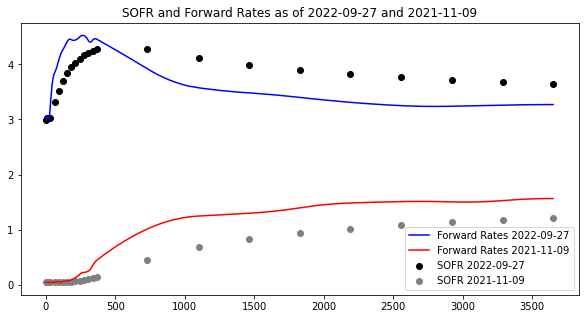

In [346]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-1]

plt.figure(figsize=(10, 5))

plt.plot([d for d in range(len([d for d in all_days])+1)], 
         fwd_curves_dict[key], color='blue')
plt.plot([d for d in range(len([d for d in all_days]))], 
         fwd_curves_dict[key_init], color='red')

plt.scatter([time*360 for time in sofr_curve_i.times()[1:] if time < 11], 
            yield_curve_dict[key], color='black')
plt.scatter([time*360 for time in sofr_curve_i.times()[1:] if time < 11], 
            yield_curve_dict[key_init], color='grey')

plt.legend([f'Forward Rates {key}', f'Forward Rates {key_init}',
           f'SOFR {key}', f'SOFR {key_init}'])
plt.title(f'SOFR and Forward Rates as of {key} and {key_init}')

plt.show()

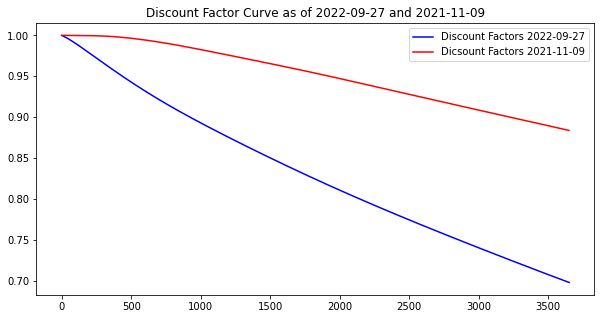

In [351]:
plt.figure(figsize=(10, 5))

plt.plot([d for d in range(len([d for d in all_days])+1)], 
         dfs_curves_dict[key], color='blue')

plt.plot([d for d in range(len([d for d in all_days]))], 
         dfs_curves_dict[key_init], color='red')

plt.legend([f'Discount Factors {key}', f'Dicsount Factors {key_init}'])

plt.title(f'Discount Factor Curve as of {key} and {key_init}')

plt.show()

## Implied Volatility Surface Construction

We get quarterly-quarterly swaps (QQ-Swaps) from the Market Overnight Forward Rates in order to imply the ATM Swap Rates:
- We have Compounded 3M Fwd OIS rates, which is used for pricing of Caps and have to annualize it to match with strike
- We use convention that we have 10 swaps, each has quarterly fixings, so we divide every swap rate by 4 and get fixing

In [223]:
qq_swaps_dict = {key : {'qq_swaps': [],
                       'dfs': [], 
                       'quarter_comps': []} for key in fwd_curves_dict.keys()}

In [239]:
# for key in fwd_curves_dict.keys():
#     date_datetime = pd.to_datetime(key)
#     year = date_datetime.year
#     month = date_datetime.month
#     day = date_datetime.day
#     today = ql.Date(day, month, year)
    
#     quarters = []

#     i = today
#     while i <= calendar.advance(today, 10, ql.Years):
#         quarters.append(calendar.advance(i, 3, ql.Months))
#         i = quarters[-1]

#     days_in_quarters = []
#     for i in quarters:
#         days_in_quarters.append(i - today)
#     days_in_quarters = [0]+days_in_quarters  
#     days_in_quarters[-1] = 3653
    
#     tenors_by_quarters = [4*i for i in range(1, 11)]
    
#     quarter_comps = []

#     for j in range(len(days_in_quarters)-1):
#         q = 1
#         for i in fwd_curves_dict[key][days_in_quarters[j]:days_in_quarters[j+1]]:
#             x = 1 + i/360/100
#             q *= x
#         quarter_comps.append(q)

#     q_swaps = []
#     for i in tenors_by_quarters:
#         k = 1
#         for j in quarter_comps[:i]:
#             k *= j
#         res = (k**(1/i)-1)*4
#         q_swaps.append(res)
    
#     qq_swaps_dict[key]['qq_swaps'] = q_swaps
    
#     #here we have dfs for every quarter(end)
#     DFs = []
#     for i in days_in_quarters[1:]:
#         try:
#             DFs.append(dfs_curves_dict[key][i])
#         except IndexError:
#             DFs.append(dfs_curves_dict[key][-1])
#     qq_swaps_dict[key]['dfs'] = DFs
    
#     qq_swaps_dict[key]['quarter_comps'] = quarter_comps

Here is the Example

In [1819]:
pd.DataFrame(qq_swaps_dict['2022-09-27']['qq_swaps']

[0.042722202160856426,
 0.04278212660699943,
 0.041186561116353104,
 0.039881962173724084,
 0.0389182705838067,
 0.038167197626648,
 0.037480081462804904,
 0.03691693658608486,
 0.03649072835189582,
 0.036130568582940725]

In [1069]:
# Save data to reuse it
# pickle_dict('qq_swaps_dict', qq_swaps_dict)

qq_swaps_dict = pickle_dict('qq_swaps_dict', serialize='rb')

We get the Cap price as a function of daily Caplets, given the inputs, Cap Vol, Strike, Expiry, Forward Curve and Discount Factors

In [251]:
def caplet_fv(tau, rate, strike, vol, expiry):
    z = ( rate - strike ) / (vol * expiry ** 0.5)
    return tau * (( rate - strike ) * norm.cdf(z) + vol * (expiry ** 0.5) * norm.pdf(z))

def cap_pv(tau, fwd_vector, dfs_vector, strike, vol, expiry):
    caplets = []
    for i in range(1, 4 * expiry + 1):
        df = dfs_vector[i-1]
        rate = (fwd_vector[i-1] - 1) * 4
        expiry = i * tau
        caplets.append(df * caplet_fv(tau, rate, strike, vol, expiry))
    return sum(caplets)

In [303]:
price_surface_dict = {key : pd.DataFrame(index=vol_surface_dict[key].index,
                                        columns=[col for col in 
                                                 vol_surface_dict[key].columns
                                                 if col not in ['-0.75%', '3.50%']]) 
                      for key in vol_surface_dict.keys()}

In [306]:
# for key in price_surface_dict.keys():
#     for strike in price_surface_dict[key].columns:
#         for expiry in price_surface_dict[key].index:
#             expiry_num = int(expiry.replace('Y', ''))
            
#             if strike == 'ATM':
#                 strike_num = qq_swaps_dict[key]['qq_swaps'][expiry_num-1]
#             else:
#                 strike_num = float(strike.replace('%', '')) / 100
                
#             vol = vol_surface_dict[key].loc[expiry, strike]/10000
#             tau = 0.25

#             price_surface_dict[key].loc[expiry, strike] = cap_pv(tau, 
#                  qq_swaps_dict[key]['quarter_comps'], 
#                  qq_swaps_dict[key]['dfs'], 
#                  strike_num, vol, expiry_num) * 10000

/var/folders/zt/2mmqxh5j3ms4m8_dlf7n891c0000gn/T/ipykernel_9363/1990442262.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  z = ( rate - strike ) / (vol * expiry ** 0.5)


Here is the result

In [1826]:
price_surface_dict['2022-09-27']

,-0.25%,-0.50%,0.00%,0.25%,0.50%,0.75%,1.00%,1.50%,2.00%,2.50%,3.00%,4.00%,4.50%,5.00%,6.00%,ATM
1Y,440.393542,464.763601,416.024099,391.654704,367.285403,342.916269,318.547578,269.816512,221.137087,172.735966,125.720368,54.512788,34.01337,20.922871,7.877918,41.88187
2Y,864.614434,912.054153,817.225229,769.906015,722.679566,675.568645,628.637817,535.517607,444.101043,355.538381,272.146243,143.132869,101.582156,72.04408,37.390676,117.594767
3Y,1235.250985,1303.695751,1167.057207,1099.099454,1031.492291,964.28427,897.578606,766.263579,638.930614,517.546564,405.326447,232.860088,175.953673,134.820322,84.035787,216.621484
4Y,1579.153331,1667.167676,1491.632936,1404.561629,1318.15675,1232.490805,1147.735639,981.789114,822.259296,671.721533,533.804936,321.419243,249.971233,196.99961,129.653345,322.25529
5Y,1906.976928,2013.520746,1801.137832,1696.017047,1591.861505,1488.759063,1386.947294,1188.303006,998.199906,820.026081,657.699346,406.845344,321.290218,257.169417,173.172865,427.828618
6Y,2220.381217,2344.624359,2096.896161,1974.574286,1853.342955,1733.612426,1615.53798,1385.512787,1166.391043,961.920052,776.388832,489.058306,389.934276,314.780652,215.254425,531.690376
7Y,2514.91544,2656.394655,2374.827926,2235.837766,2098.362023,1962.509213,1828.899739,1569.433227,1322.895021,1093.772747,886.703768,565.795967,454.302296,369.346014,255.50836,632.839741
8Y,2796.608452,2954.622831,2640.025944,2484.911839,2331.571438,2180.407633,2031.618294,1743.45944,1470.818552,1217.979057,990.273533,638.51639,515.98579,421.861066,295.175867,730.136377
9Y,3070.610653,3244.680574,2898.143524,2727.599285,2559.090648,2392.741224,2229.427845,1913.606979,1615.019256,1339.773472,1092.728107,710.825313,577.647656,474.913834,335.627669,825.346053
10Y,3336.212096,3525.626508,3148.561533,2962.69433,2779.383088,2598.441626,2420.879191,2077.775698,1754.342841,1456.892907,1190.527892,779.374174,634.750892,523.806347,372.956258,916.704045


In [1068]:
# Save data to reuse it
# pickle_dict('price_surface_dict', price_surface_dict)

price_surface_dict = pickle_dict('price_surface_dict', serialize='rb')

We can check the prices on one slice to see that they are close to the market ones

In [315]:
prices_diff_example = pd.DataFrame(price_surface_dict['2022-09-27'].values - prices.values,
                                  index=prices.index, columns=prices.columns)

In [1827]:
prices_diff_example

,-0.25%,-0.50%,0.00%,0.25%,0.50%,0.75%,1.00%,1.50%,2.00%,2.50%,3.00%,4.00%,4.50%,5.00%,6.00%,ATM
1.0,0.393542,-0.236399,0.024099,0.654704,1.285403,1.916269,1.547578,2.816512,3.137087,3.735966,3.720368,2.912788,2.11337,1.522871,0.677918,-0.61813
2.0,-1.385566,-2.945847,-0.774771,-0.093985,0.679566,1.568645,1.637817,3.517607,4.101043,5.538381,5.146243,4.132869,3.682156,2.84408,1.590676,-2.405233
3.0,0.250985,-0.304249,1.057207,2.099454,2.492291,3.28427,4.578606,6.263579,6.930614,7.546564,8.326447,6.860088,4.953673,4.820322,2.935787,-2.378516
4.0,-1.846669,-2.832324,-1.367064,0.561629,1.15675,2.490805,2.735639,4.789114,6.259296,7.721533,7.804936,6.419243,5.971233,4.99961,2.653345,-1.74471
5.0,-4.023072,-5.479254,-2.862168,-0.982953,-0.138495,0.759063,1.947294,4.303006,6.199906,7.026081,7.699346,6.845344,5.290218,5.169417,3.172865,-2.171382
6.0,-7.618783,-9.375641,-6.103839,-4.425714,-3.657045,-1.387574,-0.46202,2.512787,4.391043,5.920052,6.388832,6.058306,4.934276,3.780652,2.254425,-1.309624
7.0,-4.08456,-5.605345,-2.172074,-1.162234,0.362023,2.509213,3.899739,6.433227,7.895021,9.772747,9.703768,8.795967,7.302296,6.346014,4.50836,-0.160259
8.0,-2.391548,-4.377169,-0.974056,0.911839,2.571438,4.407633,5.618294,8.45944,10.818552,11.979057,12.273533,10.51639,8.98579,7.861066,5.175867,0.136377
9.0,-0.389347,-2.319426,1.143524,3.599285,5.090648,6.741224,8.427845,11.606979,13.019256,14.773472,14.728107,11.825313,10.647656,8.913834,6.627669,1.346053
10.0,-9.787904,-12.373492,-7.438467,-5.30567,-3.616912,-1.558374,0.879191,3.775698,6.342841,8.892907,9.527892,8.374174,6.750892,5.806347,3.956258,1.704045


Average error is:

In [337]:
print(f'Mean Error is {round(np.mean(prices_diff_example).mean(), 2)} bps')

Mean Error is 2.88 bps


And check the relative difference

In [327]:
prices_rel_diff_example = pd.DataFrame(price_surface_dict['2022-09-27'].values / prices.values - 1,
                                  index=prices.index, columns=prices.columns)

In [328]:
prices_rel_diff_example

,-0.25%,-0.50%,0.00%,0.25%,0.50%,0.75%,1.00%,1.50%,2.00%,2.50%,3.00%,4.00%,4.50%,5.00%,6.00%,ATM
1.0,0.000894,-0.000508,0.000058,0.001674,0.003512,0.00562,0.004882,0.010549,0.01439,0.022106,0.030495,0.056449,0.06625,0.078499,0.094155,-0.014544
2.0,-0.0016,-0.00322,-0.000947,-0.000122,0.000941,0.002327,0.002612,0.006612,0.009321,0.015824,0.019274,0.029733,0.037611,0.041099,0.044432,-0.020044
3.0,0.000203,-0.000233,0.000907,0.001914,0.002422,0.003418,0.005127,0.008242,0.010966,0.014797,0.020973,0.030354,0.028969,0.037079,0.0362,-0.010861
4.0,-0.001168,-0.001696,-0.000916,0.0004,0.000878,0.002025,0.002389,0.004902,0.007671,0.011629,0.014838,0.020379,0.024472,0.02604,0.020892,-0.005385
5.0,-0.002105,-0.002714,-0.001587,-0.000579,-0.000087,0.00051,0.001406,0.003634,0.00625,0.008642,0.011845,0.017113,0.016741,0.020514,0.018664,-0.00505
6.0,-0.00342,-0.003983,-0.002902,-0.002236,-0.001969,-0.0008,-0.000286,0.001817,0.003779,0.006193,0.008297,0.012543,0.012816,0.012156,0.010584,-0.002457
7.0,-0.001622,-0.002106,-0.000914,-0.00052,0.000173,0.00128,0.002137,0.004116,0.006004,0.009015,0.011065,0.015792,0.016336,0.017482,0.017962,-0.000253
8.0,-0.000854,-0.001479,-0.000369,0.000367,0.001104,0.002026,0.002773,0.004876,0.00741,0.009933,0.01255,0.016746,0.017723,0.018988,0.017848,0.000187
9.0,-0.000127,-0.000714,0.000395,0.001321,0.001993,0.002825,0.003795,0.006103,0.008127,0.01115,0.013662,0.016917,0.018779,0.019128,0.020145,0.001634
10.0,-0.002925,-0.003497,-0.002357,-0.001788,-0.0013,-0.000599,0.000363,0.00182,0.003629,0.006142,0.008068,0.010861,0.01075,0.011209,0.010722,0.001862


In [334]:
print(f'Relative Mean Error is {round(np.mean(prices_rel_diff_example).mean() * 100, 2)}%')

Relative Mean Error is 0.88%


In [362]:
vol_surface_dict[key_init]

,-0.25%,-0.50%,-0.75%,0.00%,0.25%,0.50%,0.75%,1.00%,1.50%,2.00%,2.50%,3.00%,3.50%,4.00%,4.50%,5.00%,6.00%,ATM
1Y,30.6,31.8,34.6,33.2,38.7,46.4,55.1,64.3,82.8,101.1,119.0,136.6,153.8,170.8,187.5,204.0,236.6,36.8
2Y,39.9,43.8,49.0,41.0,46.8,53.9,61.1,68.0,81.7,95.6,109.5,123.3,137.1,150.8,164.3,177.6,203.9,53.9
3Y,52.9,57.0,61.4,51.9,55.5,60.6,65.9,71.2,82.8,95.4,108.5,121.7,134.9,147.9,160.8,173.5,198.4,65.6
4Y,61.3,64.4,67.4,60.0,62.1,65.7,69.7,74.0,83.7,94.6,106.2,118.1,129.9,141.8,153.4,165.0,187.6,71.8
5Y,64.8,66.8,68.5,63.9,65.5,68.4,71.7,75.3,83.5,92.9,102.9,113.3,123.7,134.1,144.5,154.7,174.9,74.7
6Y,66.0,67.2,68.0,65.5,66.9,69.4,72.2,75.3,82.4,90.5,99.2,108.3,117.4,126.6,135.7,144.8,162.8,76.0
7Y,66.5,67.2,67.5,66.3,67.6,69.8,72.3,75.0,81.3,88.5,96.3,104.4,112.6,121.0,129.3,137.6,154.1,76.3
8Y,66.8,67.1,67.1,66.8,68.0,69.9,72.2,74.6,80.3,86.8,93.8,101.3,108.9,116.6,124.4,132.2,147.6,76.3
9Y,66.9,66.9,66.7,67.0,68.1,69.9,71.9,74.1,79.3,85.3,91.9,98.8,106.0,113.3,120.7,128.1,142.8,76.1
10Y,66.8,66.7,66.2,67.1,68.1,69.7,71.5,73.6,78.3,83.9,90.1,96.6,103.5,110.4,117.5,124.5,138.7,75.7


## Volatility Interpolation

In [722]:
vol_surface_int_dict = {key : {'vol_surface':pd.DataFrame(index=vol_surface_dict[key].index,
                                          columns=vol_surface_dict[key].columns),
                               'price_surface': pd.DataFrame(index=vol_surface_dict[key].index,
                                          columns=vol_surface_dict[key].columns)}
                        for key in vol_surface_dict.keys()}

In [723]:
vol_surface_dict['2022-09-13'].shape

(10, 18)

Create the 5-degree Spline to get interpolated volatilities per each smile:

In [733]:
# for key in vol_surface_int_dict.keys():
#     print(key)
#     atm_replace = f'{round(qq_swaps_dict[key]["qq_swaps"][0]*100,2):.1f}'
    
#     vol_surface_dict[key].rename(columns={'ATM':f'{atm_replace}%'}, inplace=True)
#     vol_surface_dict[key].columns = [f'{float(val.replace("%", "")):.2f}%' for val in vol_surface_dict[key].columns]
    
#     # Sort Strikes
#     tenors = [float(tenor.replace('Y', '')) for tenor in list(vol_surface_dict[key].index)]
#     strikes = [float(strike.replace('%', '')) for strike in list(set(list(vol_surface_dict[key].columns)))]

#     vol_surface_dict[key] = vol_surface_dict[key][[f'{strike:.2f}'+'%' for strike in sorted(strikes)]]

#     # Convert to Numbers
#     strikes = [float(strike.replace('%', ''))/ 100 for strike in list(vol_temp.columns)]
#     strikes_new = [np.arange(atm_i - 0.01, atm_i + 0.0125, 0.0025) 
#                    for atm_i in qq_swaps_dict[key]["qq_swaps"]]

#     vol_temp_new = pd.DataFrame(index=range(len(tenors)), 
#                                 columns=range(len(strikes_new[0])))
    
#     # Interpolate
#     for i in range(vol_surface_dict[key].shape[0]):
#         x = strikes
#         y = vol_surface_dict[key].iloc[i, :].values
#         f = interpolate.UnivariateSpline(x, y, k=5)

#         strike_i = strikes_new[i]
#         vol_new = f(strike_i)
    
#         for j in range(len(vol_new)):
#             try:
#                 vol_temp_new.iloc[i, j] = vol_new[j]
#             except IndexError:
#                 pass
            
#     # Address the NaNs
#     vol_temp_new = vol_temp_new.T.fillna(method='ffill').T
#     new_cols = [f'ATM-{25*i}' for i in \
#                 range(4, 0, -1)]+['ATM']+[f'ATM+{25*i}' for i in range(1, 5)]

#     # Format data
#     vol_temp_new.columns = new_cols
#     vol_temp_new.index = tenors
    
#     K = np.arange(-100, 125, 25)
#     vol_temp_new.columns = K
    
#     vol_surface_int_dict[key]['vol_surface'] = vol_temp_new
    
#     # Calculate the Price matrix
#     pv_temp_new = vol_temp_new.copy()
#     for i in range(len(strikes_new)):
#         for j in range(len(strikes_new[i])):
#             expiry = int(pv_temp_new.index[i])
#             strike = strikes_new[i][j]
#             vol = vol_temp_new.iloc[i, min(vol_temp_new.shape[1]-1, j)] / 10000
#             tau = 0.25
#             pv_temp_new.iloc[i, min(vol_temp_new.shape[1]-1, j)] = cap_pv(tau, 
#                   qq_swaps_dict[key]['quarter_comps'], 
#                   qq_swaps_dict[key]['dfs'], 
#                   strike, vol, expiry) * 10000
    
#     pv_temp_new.columns = K
#     vol_surface_int_dict[key]['price_surface'] = pv_temp_new

2022-09-27
2022-09-26
2022-09-23
2022-09-22
2022-09-21
2022-09-20
2022-09-19
2022-09-16
2022-09-15
2022-09-14
2022-09-13
2022-09-12
2022-09-09
2022-09-08
2022-09-07
2022-09-06
2022-09-05
2022-09-02
2022-09-01
2022-08-31
2022-08-30
2022-08-29
2022-08-26
2022-08-25
2022-08-24
2022-08-23
2022-08-22
2022-08-19
2022-08-18
2022-08-17
2022-08-16
2022-08-15
2022-08-12
2022-08-11
2022-08-10
2022-08-09
2022-08-08
2022-08-05
2022-08-04
2022-08-03
2022-08-02
2022-08-01
2022-07-29
2022-07-28
2022-07-27
2022-07-26
2022-07-25
2022-07-22
2022-07-21
2022-07-20
2022-07-19
2022-07-18
2022-07-15
2022-07-14
2022-07-13
2022-07-12
2022-07-11
2022-07-08
2022-07-07
2022-07-06
2022-07-05
2022-07-04
2022-07-01
2022-06-30
2022-06-29
2022-06-28
2022-06-27
2022-06-24
2022-06-23
2022-06-22
2022-06-21
2022-06-20
2022-06-17
2022-06-16
2022-06-15
2022-06-14
2022-06-13
2022-06-10
2022-06-09
2022-06-08
2022-06-07
2022-06-06
2022-06-03
2022-06-02
2022-06-01
2022-05-31
2022-05-30
2022-05-27
2022-05-26
2022-05-25
2022-05-24

In [1077]:
# Save data to reuse it
# pickle_dict('vol_surface_int_dict', vol_surface_int_dict)

vol_surface_int_dict = pickle_dict('vol_surface_int_dict', serialize='rb')

Here is our interpolated volatility surface

In [735]:
vol_surface_int_dict['2021-11-09']['vol_surface']

,-100,-75,-50,-25,0,25,50,75,100
1.0,36.879176,32.493270,31.078558,31.849497,34.406792,38.524366,43.936706,50.179959,56.748803
2.0,45.038807,39.570780,41.217824,50.636831,49.645523,51.153025,59.987746,65.593634,67.686038
3.0,53.188185,52.035331,62.270712,59.171975,57.925982,65.091370,69.340089,70.856092,74.438572
4.0,59.418613,65.471634,68.446312,62.967415,66.558435,71.730657,73.394633,75.026378,79.674102
5.0,64.120089,72.090413,68.590269,66.823569,70.891596,73.574952,75.551575,78.036432,81.710332
6.0,68.337491,73.728787,68.116796,69.050376,72.534178,74.609571,76.187520,78.547846,82.157621
7.0,71.396720,72.941407,68.191194,70.331133,73.367423,74.949181,76.248337,78.579376,82.141944
8.0,72.952254,71.925845,68.474500,70.990142,73.706698,74.882119,76.019956,78.363969,81.842542
9.0,73.454780,71.035634,68.677307,71.278418,73.625817,74.531800,75.622761,77.942720,81.294113
10.0,73.317750,70.322737,68.704529,71.304175,73.417072,74.114435,75.144135,77.413305,80.628251


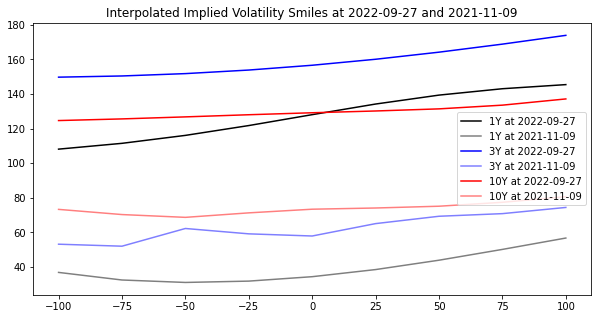

In [737]:
plt.figure(figsize=(10, 5))

key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-1]

strikes = vol_surface_int_dict[key]['vol_surface'].columns

plt.plot(strikes, vol_surface_int_dict[key]['vol_surface'].iloc[0, :], color='black')
plt.plot(strikes, vol_surface_int_dict[key_init]['vol_surface'].iloc[0, :], color='black',
        alpha=0.5)
plt.plot(strikes, vol_surface_int_dict[key]['vol_surface'].iloc[2, :], color='blue')
plt.plot(strikes, vol_surface_int_dict[key_init]['vol_surface'].iloc[2, :], color='blue',
        alpha=0.5)
plt.plot(strikes, vol_surface_int_dict[key]['vol_surface'].iloc[9, :], color='red')
plt.plot(strikes, vol_surface_int_dict[key_init]['vol_surface'].iloc[9, :], color='red',
        alpha=0.5)


plt.legend([f'1Y at {key}', f'1Y at {key_init}',
           f'3Y at {key}', f'3Y at {key_init}',
           f'10Y at {key}', f'10Y at {key_init}'])

plt.title(f'Interpolated Implied Volatility Smiles at {key} and {key_init}')

plt.show()

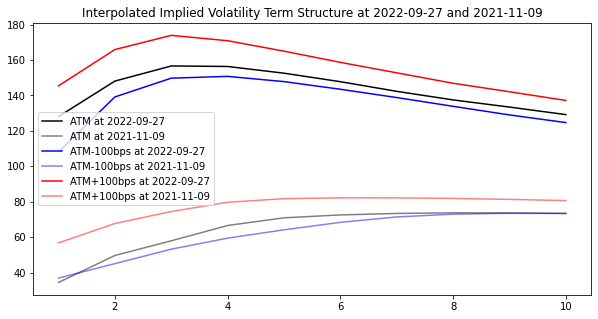

In [739]:
plt.figure(figsize=(10, 5))
cut_strikes = 0

key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-1]

strikes = vol_surface_int_dict[key]['vol_surface'].index

plt.plot(strikes, vol_surface_int_dict[key]['vol_surface'].loc[:, 0], color='black')
plt.plot(strikes, vol_surface_int_dict[key_init]['vol_surface'].loc[:, 0], color='black',
        alpha=0.5)
plt.plot(strikes, vol_surface_int_dict[key]['vol_surface'].loc[:, -100], color='blue')
plt.plot(strikes, vol_surface_int_dict[key_init]['vol_surface'].loc[:, -100], color='blue',
        alpha=0.5)
plt.plot(strikes, vol_surface_int_dict[key]['vol_surface'].loc[:, 100], color='red')
plt.plot(strikes, vol_surface_int_dict[key_init]['vol_surface'].loc[:, 100], color='red',
        alpha=0.5)


plt.legend([f'ATM at {key}', f'ATM at {key_init}',
           f'ATM-100bps at {key}', f'ATM-100bps at {key_init}',
           f'ATM+100bps at {key}', f'ATM+100bps at {key_init}'])

plt.title(f'Interpolated Implied Volatility Term Structure at {key} and {key_init}')

plt.show()

And we also have price surface

In [740]:
vol_surface_int_dict['2022-09-27']['price_surface']

,-100,-75,-50,-25,0,25,50,75,100
1.0,102.385396,83.076719,66.563238,53.018391,42.171639,33.470194,26.335585,20.362638,15.400175
2.0,230.730345,196.680662,166.418339,140.153147,117.822566,99.136709,83.655232,70.864219,60.237245
3.0,381.033871,332.652587,288.944216,250.257436,216.669393,187.987822,163.802797,143.559792,126.630281
4.0,536.625009,474.478154,417.692636,366.717911,321.747452,282.693914,249.217912,220.789702,196.759216
5.0,690.488985,615.010828,545.559665,482.673041,426.639485,377.453854,334.829731,298.253465,267.054576
6.0,840.829866,752.529218,670.889876,596.525770,529.808275,470.804646,419.276552,374.728006,336.476509
7.0,987.752204,886.605542,792.580746,706.528986,629.081644,560.529855,500.768158,449.307616,405.335392
8.0,1128.682612,1017.097670,912.562162,815.629461,726.951135,647.304926,577.626207,518.815680,470.702217
9.0,1263.005971,1141.077410,1027.475677,922.014602,824.298413,734.610929,654.863829,588.663330,537.186852
10.0,1393.514829,1260.860140,1137.315841,1022.546933,915.848070,817.266796,728.862257,655.159187,598.593369


## 3D Volatility Surface Plot

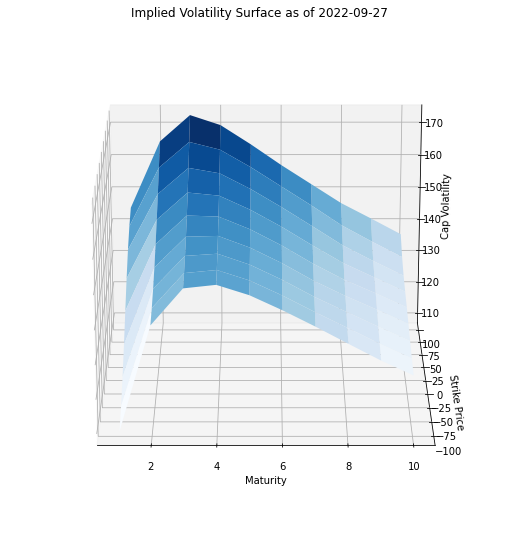

In [741]:
Ts, Ks = np.meshgrid(range(1,11), K)
vol_matrix = np.zeros((len(range(1,11)), len(K)))

def vol_plot(tenor, strike):
    return vol_surface_int_dict[key]['vol_surface'].loc[tenor, strike]

vol_3d=np.vectorize(vol_plot)
Vol = vol_3d(Ts, Ks)

fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)
ax.plot_surface(Ts, Ks, Vol, cmap = "Blues")
ax.view_init(20,270)
plt.xlabel('Maturity')
plt.ylabel('Strike Price')
ax.set_zlabel('Cap Volatility')
plt.title(f'Implied Volatility Surface as of {key}')

plt.show()

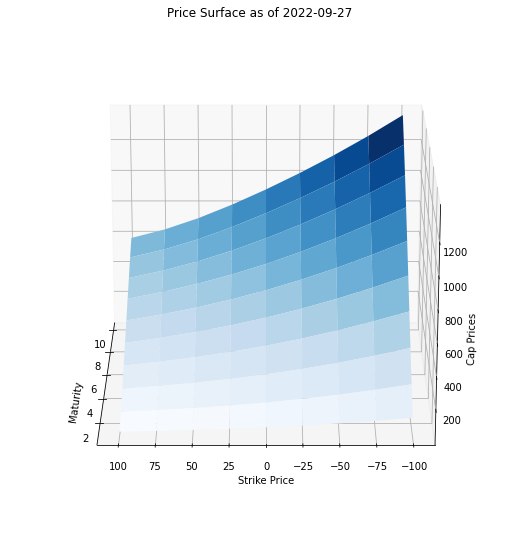

In [742]:
Ts, Ks = np.meshgrid(range(1,11), K)
vol_matrix = np.zeros((len(range(1,11)), len(K)))

def vol_plot(tenor, strike):
    return vol_surface_int_dict[key]['price_surface'].loc[tenor, strike]

vol_3d=np.vectorize(vol_plot)
Vol = vol_3d(Ts, Ks)

fig = plt.figure(figsize=(10,7))
ax = Axes3D(fig)
ax.plot_surface(Ts, Ks, Vol, cmap = "Blues")
ax.view_init(20,180)
plt.xlabel('Maturity')
plt.ylabel('Strike Price')
ax.set_zlabel('Cap Prices')
plt.title(f'Price Surface as of {key}')

plt.show()

## Risk-Neutral Probabilty Matrix

We solve Breeden-Litzenberger Numerically

\begin{align}
f(K) &= e^{rT} \frac{\partial^2 C(K,T)}{\partial K^2} \\
&\approx e^{rT} \frac{C(K+\Delta_K,T)-2C(K,T)+C(K-\Delta_K, T)}{(\Delta_K)^2}
\end{align}

In [743]:
rn_pdf_dict = {key : pd.DataFrame() for key in vol_surface_int_dict.keys()}

Here we get annual DFs and after that convert them to ZC Bonds, because probablities are measured in future terms

In [751]:
def breedenlitzenberger(pv_matrix, FVs):
    pdf_implied = pv_matrix.copy()
    tenors = range(1, len(pv_matrix.loc[:,0])+1)
    strikes = pv_matrix.columns
    for t in tenors:
        for k in strikes:
            if k == -100 or k == 100:
                pdf_implied.loc[t,k] = "NaN"
            else:
                pdf_implied.loc[t,k] = FVs[t-1] * (pv_matrix.loc[t, k + 25] - 2 * pv_matrix.loc[t, k] + pv_matrix.loc[t, k - 25] ) / (25**2)
    return pdf_implied

In [752]:
def prob(bl_pdf):
    prob_values = bl_pdf.copy()
    for t in range(1,11):
        prob_values.loc[t,:] = abs(bl_pdf.loc[t,:])/sum(abs(bl_pdf.loc[t,:]))
    return prob_values

In [753]:
# for key in rn_pdf_dict.keys():
#     print(key)
#     DFs_yearly = [qq_swaps_dict[key]['dfs'][3 + 4*i] for i in range(10)]
#     FVs = [1/DFs_yearly[i] for i in range(10)]
    
#     rn_pdf_dict[key] = prob(breedenlitzenberger(vol_surface_int_dict[key]['price_surface'], 
#                                            FVs).iloc[:,1:-1])

2022-09-27
2022-09-26
2022-09-23
2022-09-22
2022-09-21
2022-09-20
2022-09-19
2022-09-16
2022-09-15
2022-09-14
2022-09-13
2022-09-12
2022-09-09
2022-09-08
2022-09-07
2022-09-06
2022-09-05
2022-09-02
2022-09-01
2022-08-31
2022-08-30
2022-08-29
2022-08-26
2022-08-25
2022-08-24
2022-08-23
2022-08-22
2022-08-19
2022-08-18
2022-08-17
2022-08-16
2022-08-15
2022-08-12
2022-08-11
2022-08-10
2022-08-09
2022-08-08
2022-08-05
2022-08-04
2022-08-03
2022-08-02
2022-08-01
2022-07-29
2022-07-28
2022-07-27
2022-07-26
2022-07-25
2022-07-22
2022-07-21
2022-07-20
2022-07-19
2022-07-18
2022-07-15
2022-07-14
2022-07-13
2022-07-12
2022-07-11
2022-07-08
2022-07-07
2022-07-06
2022-07-05
2022-07-04
2022-07-01
2022-06-30
2022-06-29
2022-06-28
2022-06-27
2022-06-24
2022-06-23
2022-06-22
2022-06-21
2022-06-20
2022-06-17
2022-06-16
2022-06-15
2022-06-14
2022-06-13
2022-06-10
2022-06-09
2022-06-08
2022-06-07
2022-06-06
2022-06-03
2022-06-02
2022-06-01
2022-05-31
2022-05-30
2022-05-27
2022-05-26
2022-05-25
2022-05-24

In [1078]:
# Save data to reuse it
# pickle_dict('rn_pdf_dict', rn_pdf_dict)

rn_pdf_dict = pickle_dict('rn_pdf_dict', serialize='rb')

Let's see the example:

In [1829]:
rn_pdf_dict['2022-09-27']

,-75,-50,-25,0,25,50,75
1.0,0.194839,0.206928,0.188070,0.149538,0.109216,0.080973,0.070436
2.0,0.161696,0.170652,0.167983,0.155606,0.136807,0.114866,0.092391
3.0,0.148574,0.159660,0.162113,0.156000,0.142966,0.125335,0.105352
4.0,0.140657,0.152449,0.157525,0.155233,0.146329,0.132431,0.115376
5.0,0.136113,0.148253,0.154769,0.154653,0.148185,0.136584,0.121442
6.0,0.133095,0.145362,0.152782,0.154126,0.149364,0.139454,0.125817
7.0,0.124564,0.139451,0.150494,0.155586,0.153742,0.145190,0.130973
8.0,0.111065,0.119783,0.130049,0.142302,0.157039,0.171230,0.168533
9.0,0.118191,0.115549,0.109931,0.113960,0.141094,0.192281,0.208993
10.0,0.119734,0.115331,0.106061,0.106686,0.133748,0.193214,0.225227


And we see that they sum up to 1

In [755]:
rn_pdf_dict['2022-09-27'].sum(axis=1)

1.0     1.0
2.0     1.0
3.0     1.0
4.0     1.0
5.0     1.0
6.0     1.0
7.0     1.0
8.0     1.0
9.0     1.0
10.0    1.0
dtype: float64

### PDFs Charts

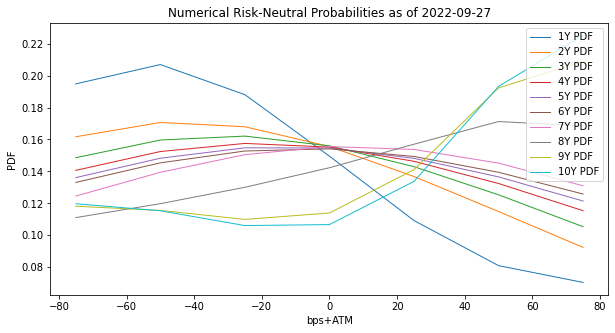

In [756]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-1]

new_K = K[1:-1]
fig = plt.figure(figsize=(10,5))
for i in range(1,11):
    plt.plot(new_K, rn_pdf_dict[key].loc[i,:], linewidth = 1, linestyle='-', label=str(i)+'Y PDF')
plt.gca().set_prop_cycle(None)

plt.xlabel("bps+ATM")
plt.ylabel("PDF")
plt.title(f'Numerical Risk-Neutral Probabilities as of {key}')
plt.legend()
plt.show()

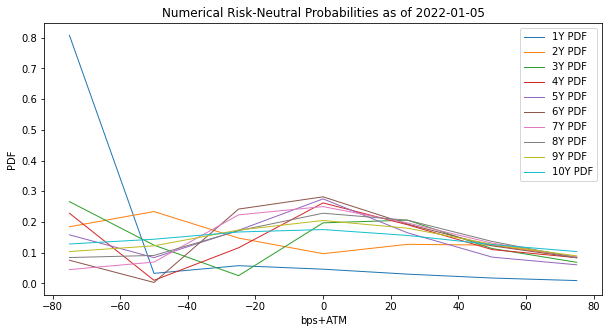

In [757]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-42]

new_K = K[1:-1]
fig = plt.figure(figsize=(10,5))
for i in range(1,11):
    plt.plot(new_K, rn_pdf_dict[key_init].loc[i,:], linewidth = 1, linestyle='-', label=str(i)+'Y PDF')
plt.gca().set_prop_cycle(None)

plt.xlabel("bps+ATM")
plt.ylabel("PDF")
plt.title(f'Numerical Risk-Neutral Probabilities as of {key_init}')
plt.legend()
plt.show()

# Transition Matrix

Now let's estimate the transition matrix

In [758]:
transition_matrix_dict = {key : pd.DataFrame() for key in rn_pdf_dict.keys()}

In [805]:
# for key in transition_matrix_dict.keys():
#     print(key)
#     strks = rn_pdf_dict[key].T.shape[0]

#     P = pd.DataFrame(np.zeros((strks,strks)), 
#                      index = rn_pdf_dict[key].T.index, 
#                      columns = rn_pdf_dict[key].T.index)

#     P.loc[0,:] = rn_pdf_dict[key].T.iloc[:,0].values
#     P = P.values
#     pi_0 = [0 if strike != 0 else 1 for strike in rn_pdf_dict[key].T.index]
#     pi_1 = rn_pdf_dict[key].T.iloc[:, 0].values

#     def objective(P):
#         x1, x2, x3, x4, x5, x6, x7 = P.reshape(strks, strks)

#         P_tot = np.vstack([x1, x2, x3, x4, x5, x6, x7])

#         res1 = 0

#         for i in range(strks):
#             res1 = res1 + np.sum(np.abs(rn_pdf_dict[key].T.iloc[:,i + 1].values - \
#                                         np.dot(pi_0, np.linalg.matrix_power(P_tot, i+ 2)))**1)

#         cross_results = np.zeros(strks)

#         for i in range(strks):
#             for j in range(strks - i):
#                 cross_results[i] = cross_results[i] + \
#                                     np.sum(np.abs(rn_pdf_dict[key].T.iloc[:, strks - j].values - \
#                                               np.dot(rn_pdf_dict[key].T.iloc[:,strks - 1 - i - j].values, 
#                                                 np.linalg.matrix_power(P_tot, i + 1)))**1)
#         res = res1 + sum(cross_results)
#         return res


#     constr = []
#     middle_strk = strks // 2

#     res = optimize.minimize(objective, P, method='SLSQP',
#                         tol=1e-5,bounds=[(0.0, 1.0)]*strks*strks, 
#         constraints=({'type':'eq', 'fun': lambda X: 1.0 - sum([X[strks * 0 + i] for i in range(strks)])},
#                      {'type':'eq', 'fun': lambda X: 1.0 - sum([X[strks * 1 + i] for i in range(strks)])},
#                      {'type':'eq', 'fun': lambda X: 1.0 - sum([X[strks * 2 + i] for i in range(strks)])},

#                      {'type':'eq', 'fun': lambda X: pi_1[0]-X[strks * middle_strk + 0]},
#                      {'type':'eq', 'fun': lambda X: pi_1[1]-X[strks * middle_strk + 1]},
#                      {'type':'eq', 'fun': lambda X: pi_1[2]-X[strks * middle_strk + 2]},
#                      {'type':'eq', 'fun': lambda X: pi_1[3]-X[strks * middle_strk + 3]},
#                      {'type':'eq', 'fun': lambda X: pi_1[4]-X[strks * middle_strk + 4]},
#                      {'type':'eq', 'fun': lambda X: pi_1[5]-X[strks * middle_strk + 5]},
#                      {'type':'eq', 'fun': lambda X: pi_1[6]-X[strks * middle_strk + 6]},

#                      {'type':'eq', 'fun': lambda X: 1.0 - sum([X[strks * 4 + i] for i in range(strks)])},
#                      {'type':'eq', 'fun': lambda X: 1.0 - sum([X[strks * 5 + i] for i in range(strks)])},
#                      {'type':'eq', 'fun': lambda X: 1.0 - sum([X[strks * 6 + i] for i in range(strks)])}
#                      ))
    
#     rec_df = pd.DataFrame(res.x.reshape(strks, strks), index=rn_pdf_dict[key].T.index,
#                      columns=rn_pdf_dict[key].T.index)
    
#     transition_matrix_dict[key] = rec_df

2022-09-27
2022-09-26
2022-09-23
2022-09-22
2022-09-21
2022-09-20
2022-09-19
2022-09-16
2022-09-15
2022-09-14
2022-09-13
2022-09-12
2022-09-09
2022-09-08
2022-09-07
2022-09-06
2022-09-05
2022-09-02
2022-09-01
2022-08-31
2022-08-30
2022-08-29
2022-08-26
2022-08-25
2022-08-24
2022-08-23
2022-08-22
2022-08-19
2022-08-18
2022-08-17
2022-08-16
2022-08-15
2022-08-12
2022-08-11
2022-08-10
2022-08-09
2022-08-08
2022-08-05
2022-08-04
2022-08-03
2022-08-02
2022-08-01
2022-07-29
2022-07-28
2022-07-27
2022-07-26
2022-07-25
2022-07-22
2022-07-21
2022-07-20
2022-07-19
2022-07-18
2022-07-15
2022-07-14
2022-07-13
2022-07-12
2022-07-11
2022-07-08
2022-07-07
2022-07-06
2022-07-05
2022-07-04
2022-07-01
2022-06-30
2022-06-29
2022-06-28
2022-06-27
2022-06-24
2022-06-23
2022-06-22
2022-06-21
2022-06-20
2022-06-17
2022-06-16
2022-06-15
2022-06-14
2022-06-13
2022-06-10
2022-06-09
2022-06-08
2022-06-07
2022-06-06
2022-06-03
2022-06-02
2022-06-01
2022-05-31
2022-05-30
2022-05-27
2022-05-26
2022-05-25
2022-05-24

In [1079]:
# Save data to reuse it
# pickle_dict('transition_matrix_dict', transition_matrix_dict)

transition_matrix_dict = pickle_dict('transition_matrix_dict', serialize='rb')

Let's look at the example of the Transition Matrix

In [806]:
transition_matrix_dict['2022-09-27']

,-75,-50,-25,0,25,50,75
-75,6.889143e-01,1.467364e-01,1.643493e-01,1.980308e-17,1.107881e-17,8.772537e-18,5.080904e-18
-50,6.511673e-18,7.909911e-02,6.630280e-03,3.804476e-01,2.629488e-01,1.673437e-01,1.035306e-01
-25,3.821182e-17,5.223131e-01,4.751570e-01,2.529892e-03,4.680678e-18,5.634808e-18,6.990003e-18
0,1.948386e-01,2.069281e-01,1.880702e-01,1.495382e-01,1.092160e-01,8.097337e-02,7.043557e-02
25,4.131939e-02,4.997899e-04,1.783062e-01,4.948350e-01,2.850396e-01,2.713681e-17,2.346598e-18
50,2.927340e-17,8.705765e-18,3.937417e-17,4.404462e-18,3.897847e-01,5.294402e-01,8.077507e-02
75,1.659542e-17,5.438438e-18,7.004841e-18,2.819991e-17,3.079491e-17,2.624750e-01,7.375250e-01


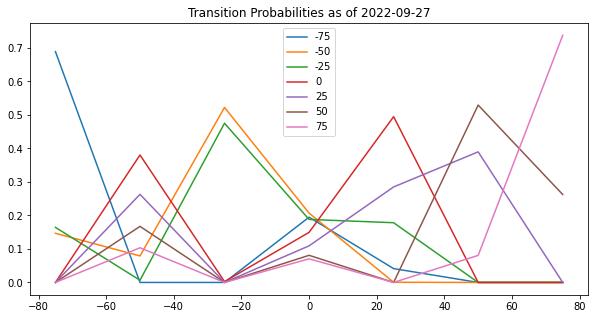

In [807]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-42]

plt.figure(figsize=(10, 5))
plt.plot(transition_matrix_dict[key])
plt.title(f'Transition Probabilities as of {key}')
plt.legend(rec_df.columns)
plt.show();

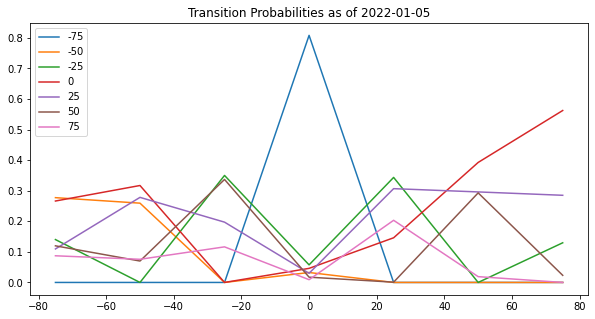

In [808]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-42]

plt.figure(figsize=(10, 5))
plt.plot(transition_matrix_dict[key_init])
plt.title(f'Transition Probabilities as of {key_init}')
plt.legend(rec_df.columns)
plt.show();

Let's look at the slices

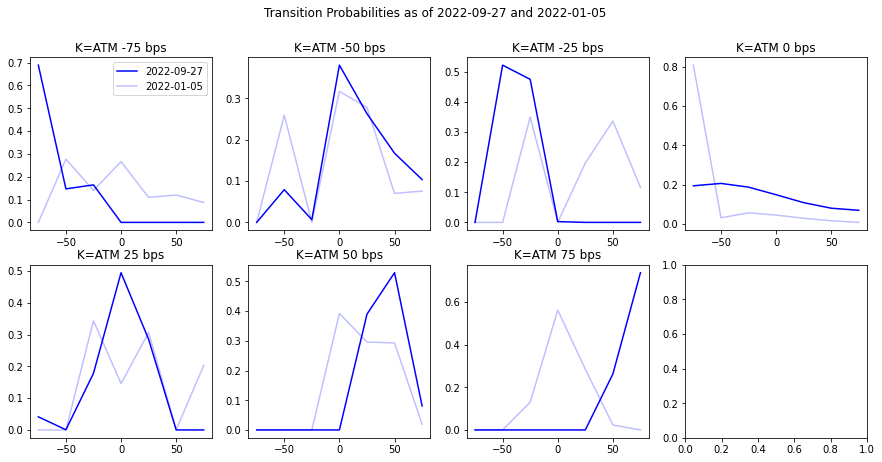

In [896]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

fig.suptitle(f'Transition Probabilities as of {key} and {key_init}')
axes = axes.flatten()

for strike in transition_matrix_dict[key].index:
    idx = list(transition_matrix_dict[key].index).index(strike)
    axes[idx].plot(transition_matrix_dict[key].loc[strike, :], color='blue')
    axes[idx].plot(transition_matrix_dict[key_init].loc[strike, :], color='blue', alpha=0.25)
    if idx == 0:
        axes[idx].legend([key, key_init])
    axes[idx].set_title(f'K=ATM {strike} bps')
    
plt.show();

# Recovered Probabilities

In [921]:
rec_prob_dict = {key : {'rec_df' : pd.DataFrame(index=transition_matrix_dict[key].index,
                                   columns=transition_matrix_dict[key].columns),
                        'eigenval' : 0,
                        'eigenvec' : 0, 
                       'expected_value': 0}
                 for key in transition_matrix_dict.keys()}

In [937]:
for key in rec_prob_dict.keys():
    eigenvals = np.linalg.eig(transition_matrix_dict[key])[0]
    eigenvecs = np.linalg.eig(transition_matrix_dict[key])[1]
    delta = eigenvals[0]
    z = 1 / eigenvecs[0]
    rec_prob_dict[key]['eigenval'] = eigenvals
    rec_prob_dict[key]['eigenvec'] = eigenvecs
    
    for i in range(len(transition_matrix_dict[key])):
        for j in range(len(transition_matrix_dict[key])):
            rec_prob_dict[key]['rec_df'].iloc[i, j] = np.abs(1/delta * transition_matrix_dict[key].iloc[i, j] * z[i] / z[j])
    # Normalize data
    rec_prob_dict[key]['rec_df'] = rec_prob_dict[key]['rec_df'] / rec_prob_dict[key]['rec_df'].sum(axis=0)
    
    rec_prob_dict[key]['expected_value'] = np.sum(rec_prob_dict[key]['rec_df'].index * \
                                                  rec_prob_dict[key]['rec_df'].sum(axis=1))

In [1080]:
# Save data to reuse it
# pickle_dict('rec_prob_dict', rec_prob_dict)

rec_prob_dict = pickle_dict('rec_prob_dict', serialize='rb')

Let's look at the examples:

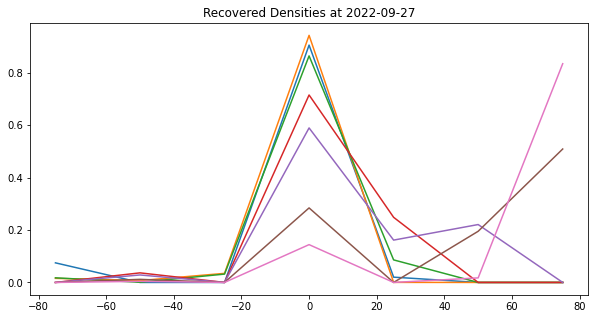

In [924]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-42]

plt.figure(figsize=(10, 5))
plt.plot(rec_prob_dict[key]['rec_df'])
plt.title(f'Recovered Densities at {key}')
plt.show()

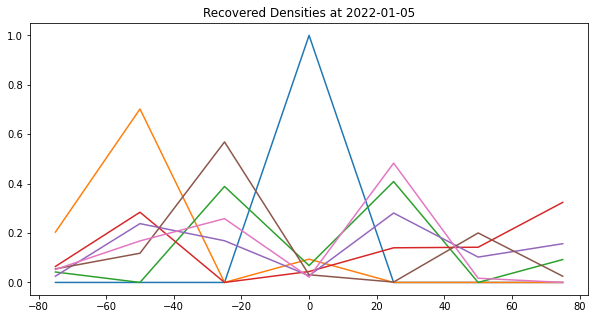

In [925]:
key = list(fwd_curves_dict.keys())[0]
key_init = list(fwd_curves_dict.keys())[-42]

plt.figure(figsize=(10, 5))
plt.plot(rec_prob_dict[key_init]['rec_df'])
plt.title(f'Recovered Densities at {key_init}')
plt.show()

And see how our expected value moves through the time:

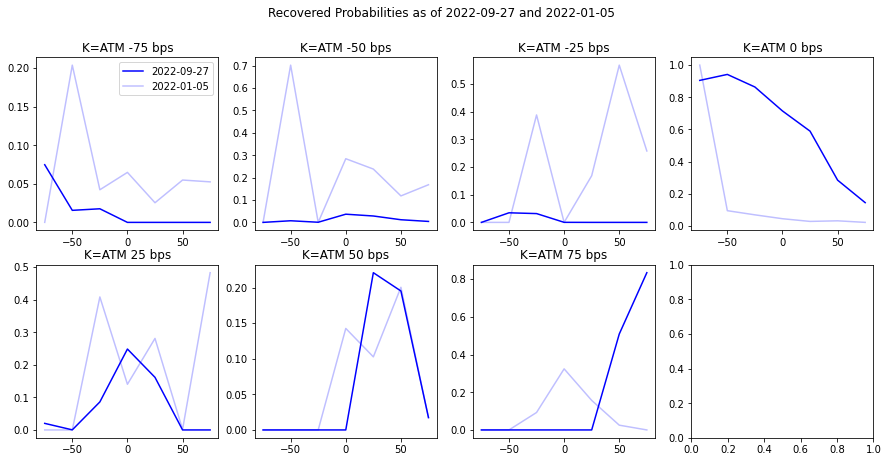

In [926]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

fig.suptitle(f'Recovered Probabilities as of {key} and {key_init}')
axes = axes.flatten()

for strike in rec_prob_dict[key]['rec_df'].index:
    idx = list(rec_prob_dict[key]['rec_df'].index).index(strike)
    axes[idx].plot(rec_prob_dict[key]['rec_df'].loc[strike, :], color='blue')
    axes[idx].plot(rec_prob_dict[key_init]['rec_df'].loc[strike, :], color='blue', alpha=0.25)
    if idx == 0:
        axes[idx].legend([key, key_init])
    axes[idx].set_title(f'K=ATM {strike} bps')
    
plt.show();

# Signal Generation

Let's also create time-series and look at the data in order to make a signal

In [1832]:
rec_prob_df = pd.DataFrame(index=list(rec_prob_dict.keys()),
                           columns=list(rec_prob_dict[key]['rec_df'].columns))

In [1833]:
for key in rec_prob_dict.keys():
    rec_prob_df.loc[key, :] = rec_prob_dict[key]['rec_df'].sum(axis=1) / rec_prob_dict[key]['rec_df'].sum(axis=1).sum()
    rec_prob_df.loc[key, 'exp_val'] = rec_prob_dict[key]['expected_value']

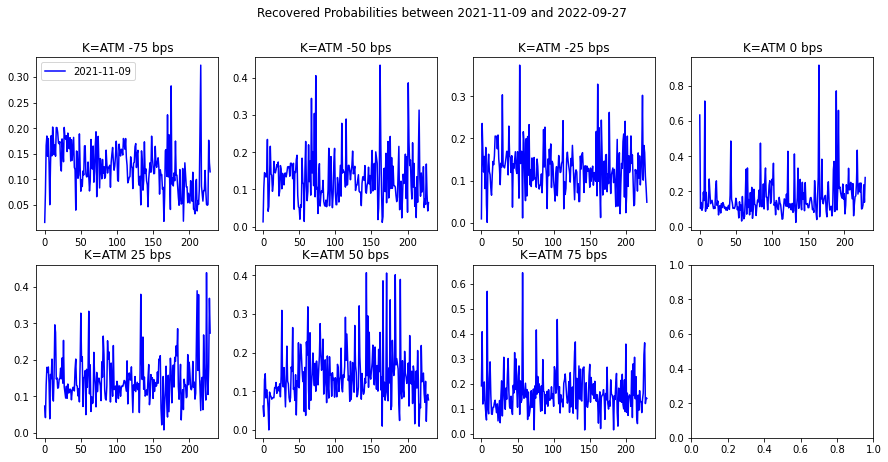

In [1834]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

fig.suptitle(f'Recovered Probabilities between {rec_prob_df.index[-1]} and {rec_prob_df.index[0]}')
axes = axes.flatten()

for strike in rec_prob_df.iloc[:, :-1].columns:
    idx = list(rec_prob_df.iloc[:, :-1].columns).index(strike)
    axes[idx].plot(rec_prob_df.loc[:, strike].values, color='blue')
    if idx == 0:
        axes[idx].legend([key, key_init])
    axes[idx].set_title(f'K=ATM {strike} bps')
    
plt.show();

# Kalman Filter

We see that we get very noisy data for the returns. Therefore, it makes sense for us to use some smoothing techniques

In [1151]:
# for column in rec_prob_df.columns[:-1]:

#     outlier_thresh = 0.95

#     # Treat y as position, and that y-dot is
#     # an unobserved state - the velocity,
#     # which is modelled as changing slowly (inertia)

#     # state vector [y,
#     #               y_dot]

#     # transition_matrix =  [[1, dt],
#     #                       [0, 1]]

#     observation_matrix = np.asarray([[1, 0]])

#     # observations:
#     t = list(range(len(rec_prob_df.index)))

#     # dt betweeen observations:
#     dt = [np.mean(np.diff(t))] + list(np.diff(t))
#     transition_matrices = np.asarray([[[1, each_dt],[0, 1]]
#                                         for each_dt in dt])

#     # observations
#     y = np.transpose(np.asarray([list(rec_prob_df.loc[:, column].values)]))

#     y = np.ma.array(y)

#     leave_1_out_cov = []

#     for i in range(len(y)):
#         y_masked = np.ma.array(copy.deepcopy(y))
#         y_masked[i] = np.ma.masked

#         kf1 = KalmanFilter(transition_matrices = transition_matrices,
#                        observation_matrices = observation_matrix)

#         kf1 = kf1.em(y_masked)

#         leave_1_out_cov.append(kf1.observation_covariance[0,0])

#     # Find indexes that contributed excessively to observation covariance
#     outliers = (leave_1_out_cov / np.mean(leave_1_out_cov)) < outlier_thresh

#     for i in range(len(outliers)):
#         if outliers[i]:
#             y[i] = np.ma.masked


#     kf1 = KalmanFilter(transition_matrices = transition_matrices,
#                        observation_matrices = observation_matrix)

#     kf1 = kf1.em(y)

#     (smoothed_state_means, smoothed_state_covariances) = kf1.smooth(y)

#     rec_prob_df.loc[:, f'{column}_K'] = smoothed_state_means[:,0]

In [1849]:
# rec_prob_df.to_pickle('rec_prob_df.pickle')

rec_prob_df = pd.read_pickle('rec_prob_df.pickle')
rec_prob_df = rec_prob_df.sort_index()

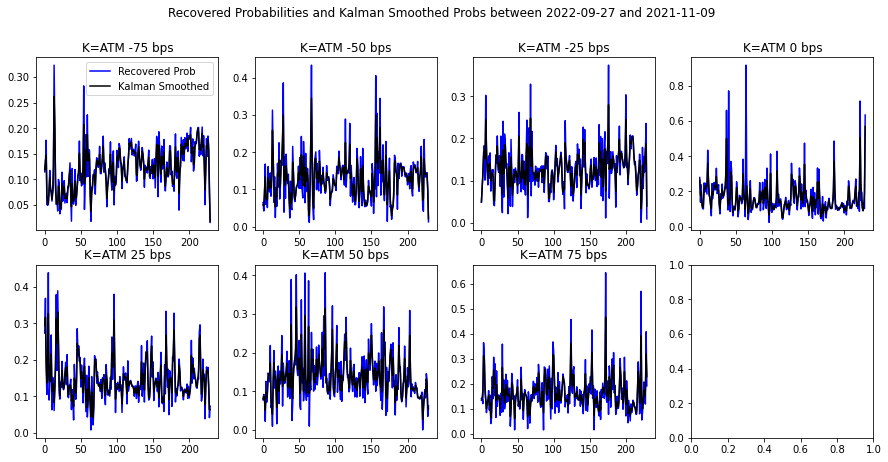

In [1850]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

fig.suptitle(f'Recovered Probabilities and Kalman Smoothed Probs between {rec_prob_df.index[-1]} and {rec_prob_df.index[0]}')
axes = axes.flatten()

for strike in rec_prob_df.iloc[:, :7].columns:
    idx = list(rec_prob_df.iloc[:, :-2].columns).index(strike)
    axes[idx].plot(rec_prob_df.loc[:, strike].values, color='blue')
    axes[idx].plot(rec_prob_df.loc[:, str(strike)+'_K'].values, color='black')

    if idx == 0:
        axes[idx].legend(['Recovered Prob', 'Kalman Smoothed'])
    axes[idx].set_title(f'K=ATM {strike} bps')
    
plt.show();

# Test for the Forward Returns

Let's calculate the mean swap rate

In [1851]:
for date in rec_prob_df.index:
    rec_prob_df.loc[date, 'mean_swap'] = yield_curve_dict[date].iloc[:, 15:25].mean(axis=1).values[0]

In [1852]:
rec_prob_df['mean_swap_fwd'] = rec_prob_df['mean_swap'].shift(-30)
rec_prob_df = rec_prob_df.dropna()

In [1853]:
rec_prob_df.head()

,-75,-50,-25,0,25,50,75,exp_val,-75_K,-50_K,-25_K,0_K,25_K,50_K,75_K,mean_swap,mean_swap_fwd
2021-11-09,0.1145,0.064408,0.048971,0.279243,0.273139,0.077766,0.141974,58.328462,0.118902,0.058253,0.049113,0.263159,0.293772,0.080696,0.135161,0.86625,1.00809
2021-11-10,0.131841,0.041973,0.083144,0.138381,0.368266,0.09199,0.144406,73.999101,0.136265,0.055833,0.083103,0.178280,0.316499,0.086916,0.144551,0.97460,1.01170
2021-11-11,0.176407,0.086784,0.110993,0.237541,0.18058,0.086456,0.121239,-16.900236,0.147011,0.092682,0.116625,0.197905,0.197829,0.077217,0.171531,0.96882,1.03716
2021-11-12,0.050257,0.168266,0.166233,0.123779,0.105405,0.022419,0.36364,102.834768,0.071179,0.134441,0.158274,0.134449,0.136782,0.050831,0.312539,0.99760,1.03578
2021-11-15,0.04894,0.059682,0.18327,0.102861,0.163048,0.125743,0.316456,160.028576,0.050596,0.080003,0.170425,0.108461,0.195873,0.097886,0.295769,1.02727,1.03430


In [1854]:
X = rec_prob_df[[col for col in rec_prob_df.columns[8:-2] if col not in ['-50_K', '0_K', '25_K']]]
# X = sm.add_constant(X)
y = rec_prob_df['mean_swap_fwd']

model = sm.OLS(y, X)

res = model.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          mean_swap_fwd   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              778.7
Date:                Tue, 18 Oct 2022   Prob (F-statistic):                   4.55e-119
Time:                        00:12:10   Log-Likelihood:                         -183.12
No. Observations:                 200   AIC:                                      374.2
Df Residuals:                     196   BIC:                                      387.4
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [1855]:
significant_values = ['-75_K', '-25_K', '50_K', '75_K']

Let's look at the data:

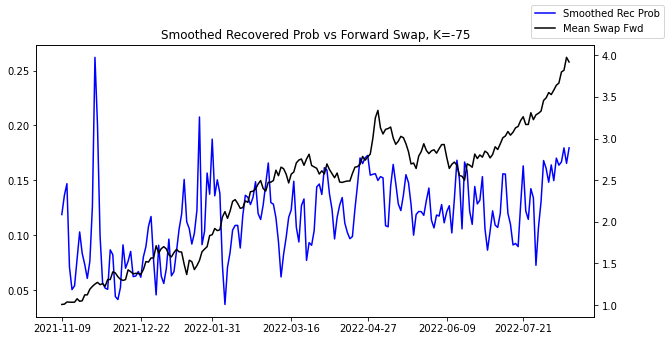

In [1856]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rec_prob_df.loc[:, '-75_K'], color='blue', label='Smoothed Rec Prob')


ax2 = ax.twinx()
ax2.plot(rec_prob_df.loc[:, 'mean_swap_fwd'], color='black', label='Mean Swap Fwd')

ax.xaxis.set_major_locator(dates.MonthLocator())

fig.legend()
plt.title('Smoothed Recovered Prob vs Forward Swap, K=-75')
plt.show()

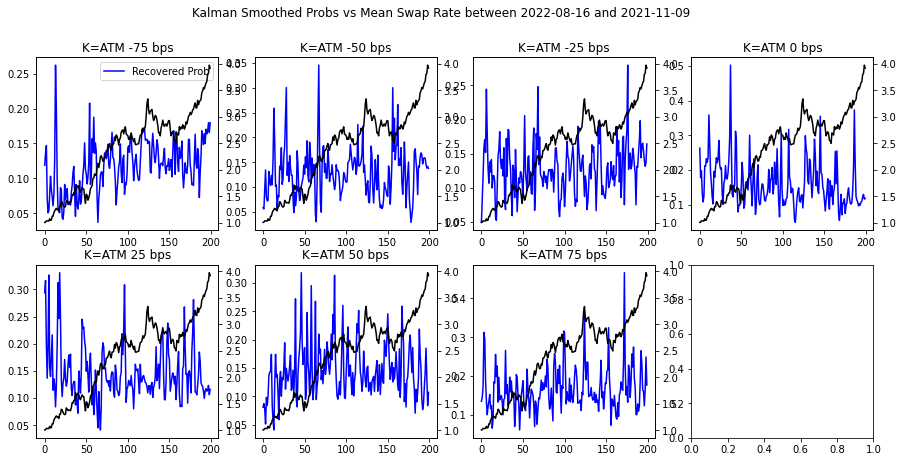

In [1857]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7))

fig.suptitle(f'Kalman Smoothed Probs vs Mean Swap Rate between {rec_prob_df.index[-1]} and {rec_prob_df.index[0]}')
axes = axes.flatten()

for strike in rec_prob_df.iloc[:, :7].columns:
    idx = list(rec_prob_df.iloc[:, :-2].columns).index(strike)
    ax2 = axes[idx].twinx()
    axes[idx].plot(rec_prob_df.loc[:, f'{strike}_K'].values, label='Smoothed Rec Prob', color='blue')
    ax2.plot(rec_prob_df.loc[:, 'mean_swap_fwd'].values, color='black')

    if idx == 0:
        axes[idx].legend(['Recovered Prob', 'Kalman Smoothed'])
    axes[idx].set_title(f'K=ATM {strike} bps')
    
plt.show();

In [1858]:
for strike in rec_prob_df.columns[:7]:
    X = rec_prob_df[[f'{strike}_K']]
#     X = sm.add_constant(X)
    y = rec_prob_df['mean_swap_fwd']

    model = sm.OLS(y, X)

    res = model.fit()

    print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:          mean_swap_fwd   R-squared (uncentered):                   0.914
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              2110.
Date:                Tue, 18 Oct 2022   Prob (F-statistic):                   6.90e-108
Time:                        00:12:12   Log-Likelihood:                         -220.65
No. Observations:                 200   AIC:                                      443.3
Df Residuals:                     199   BIC:                                      446.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Given the reasonable theoretical justification let's construct the trading strategy, which works the following way:
- If the expected value of the rate is higher than 0, we long the agregate swap curve -> Pay Fixed
- If less than 0, we short -> Receive Fixed

In [1859]:
rec_prob_df['exp_val'] = rec_prob_df[significant_values].values @ [-75, -25, 50, 75]

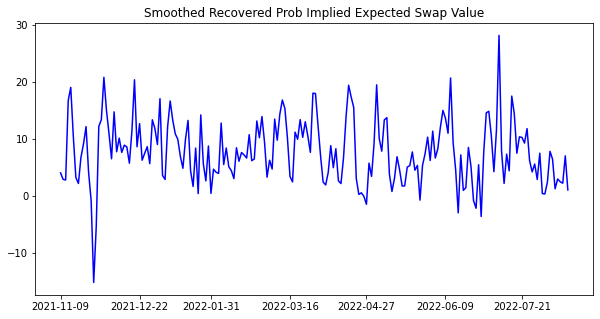

In [1860]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rec_prob_df.loc[:, 'exp_val'], color='blue', label='Smoothed Rec Prob')

ax.xaxis.set_major_locator(dates.MonthLocator())

plt.title('Smoothed Recovered Prob Implied Expected Swap Value')
plt.show()

Construct the position

In [1861]:
rec_prob_df['position'] = 0

for i in range(1, rec_prob_df.shape[0]-1):
    date = list(rec_prob_df.index)[i]
    date_fwd = list(rec_prob_df.index)[i+1]
    date_bwd = list(rec_prob_df.index)[i-1]
    
    if rec_prob_df.loc[date_bwd, 'exp_val'] > 0:
        rec_prob_df.loc[date, 'position'] = 1
        count +=1
    elif rec_prob_df.loc[date_bwd, 'exp_val'] < 0:
        rec_prob_df.loc[date, 'position'] = -1
        count +=1
    else:
        rec_prob_df.loc[date, 'position'] = 0

    if i == rec_prob_df.shape[0]-1:
        rec_prob_df.loc[date_fwd, 'position'] = 0

rec_prob_df['pnl'] = rec_prob_df['mean_swap'].diff().fillna(0) * rec_prob_df['position'].shift(1).fillna(0)
rec_prob_df['pnl_agg'] = (1 + rec_prob_df['pnl']).cumprod()

print(f'Sharpe Ratio is {round(rec_prob_df["pnl"].mean()/ rec_prob_df["pnl"].std(), 2)}')

Sharpe Ratio is 0.15


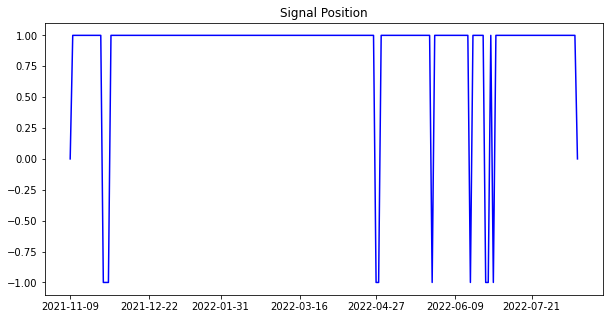

In [1862]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rec_prob_df.loc[:, 'position'], color='blue', label='Smoothed Rec Prob')

ax.xaxis.set_major_locator(dates.MonthLocator())

plt.title('Signal Position')
plt.show()

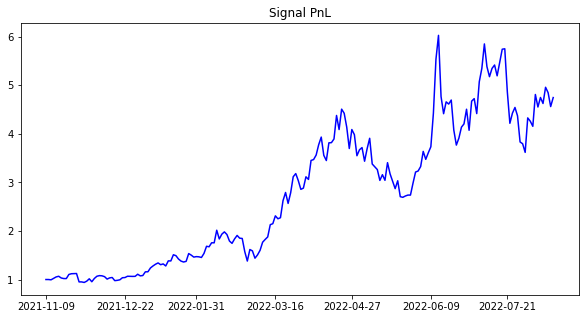

In [1863]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rec_prob_df.loc[:, 'pnl_agg'], color='blue', label='Smoothed Rec Prob')

ax.xaxis.set_major_locator(dates.MonthLocator())

plt.title('Signal PnL')
plt.show()

Let's investigate the cases when the position goes short:

In [1873]:
print(f'Mean PnL for shorts is {round(rec_prob_df[rec_prob_df.position == -1].pnl.mean(), 4)}')

Mean PnL for shorts is -0.0045


,pnl,mean_swap,position,exp_val
2021-11-19,-0.00011,0.99572,1,6.753158
2021-11-22,0.08289,1.07861,1,9.105183
2021-11-23,0.01356,1.09217,1,12.140045
2021-11-24,0.00212,1.09429,1,4.121661
2021-11-25,0.00173,1.09602,1,-0.858330
2021-11-26,-0.15358,0.94244,-1,-15.183108
2021-11-29,-0.00012,0.94256,-1,-5.341180
2021-11-30,-0.01156,0.95412,-1,12.172705
2021-12-01,0.02790,0.92622,1,13.365422
2021-12-02,0.05038,0.97660,1,20.784968


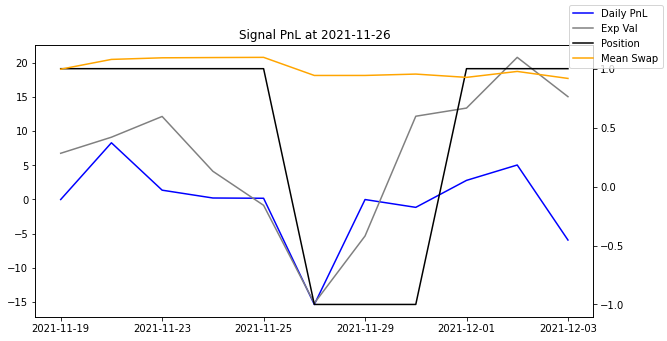

,pnl,mean_swap,position,exp_val
2021-11-22,0.08289,1.07861,1,9.105183
2021-11-23,0.01356,1.09217,1,12.140045
2021-11-24,0.00212,1.09429,1,4.121661
2021-11-25,0.00173,1.09602,1,-0.858330
2021-11-26,-0.15358,0.94244,-1,-15.183108
2021-11-29,-0.00012,0.94256,-1,-5.341180
2021-11-30,-0.01156,0.95412,-1,12.172705
2021-12-01,0.02790,0.92622,1,13.365422
2021-12-02,0.05038,0.97660,1,20.784968
2021-12-03,-0.05937,0.91723,1,15.033549


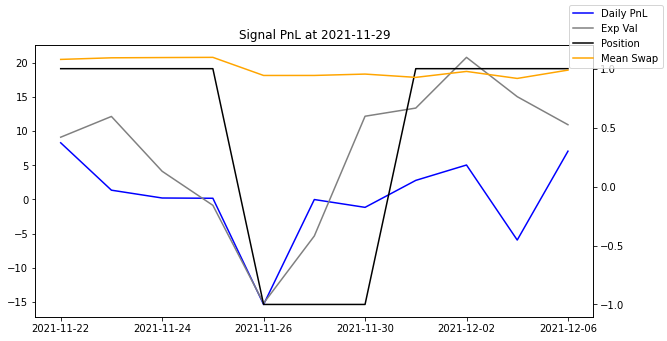

,pnl,mean_swap,position,exp_val
2021-11-23,0.01356,1.09217,1,12.140045
2021-11-24,0.00212,1.09429,1,4.121661
2021-11-25,0.00173,1.09602,1,-0.858330
2021-11-26,-0.15358,0.94244,-1,-15.183108
2021-11-29,-0.00012,0.94256,-1,-5.341180
2021-11-30,-0.01156,0.95412,-1,12.172705
2021-12-01,0.02790,0.92622,1,13.365422
2021-12-02,0.05038,0.97660,1,20.784968
2021-12-03,-0.05937,0.91723,1,15.033549
2021-12-06,0.07060,0.98783,1,10.932793


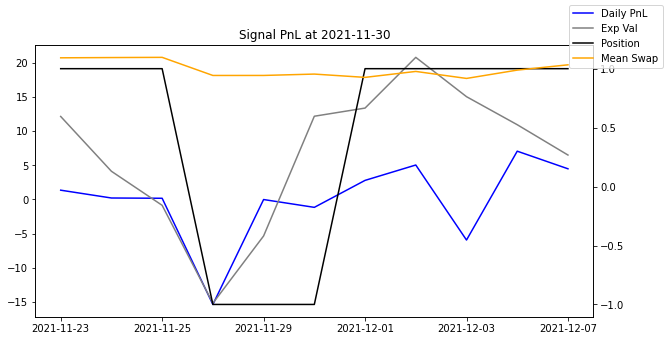

,pnl,mean_swap,position,exp_val
2022-04-20,-0.06622,2.55440,1,15.504003
2022-04-21,0.10267,2.65707,1,3.076724
2022-04-22,-0.01885,2.63822,1,0.256691
2022-04-25,-0.06453,2.57369,1,0.528700
2022-04-26,-0.10630,2.46739,1,-0.090780
2022-04-27,0.10570,2.57309,-1,-1.477216
2022-04-28,-0.02567,2.59876,-1,5.738454
2022-04-29,-0.10910,2.70786,1,3.408595
2022-05-02,0.03445,2.74231,1,9.293731
2022-05-03,0.01253,2.75484,1,19.462155


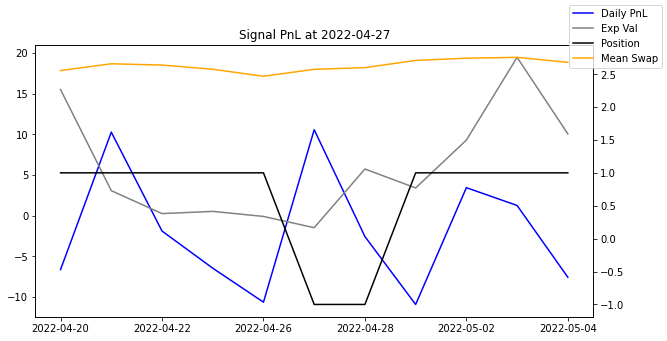

,pnl,mean_swap,position,exp_val
2022-04-21,0.10267,2.65707,1,3.076724
2022-04-22,-0.01885,2.63822,1,0.256691
2022-04-25,-0.06453,2.57369,1,0.528700
2022-04-26,-0.10630,2.46739,1,-0.090780
2022-04-27,0.10570,2.57309,-1,-1.477216
2022-04-28,-0.02567,2.59876,-1,5.738454
2022-04-29,-0.10910,2.70786,1,3.408595
2022-05-02,0.03445,2.74231,1,9.293731
2022-05-03,0.01253,2.75484,1,19.462155
2022-05-04,-0.07567,2.67917,1,10.057492


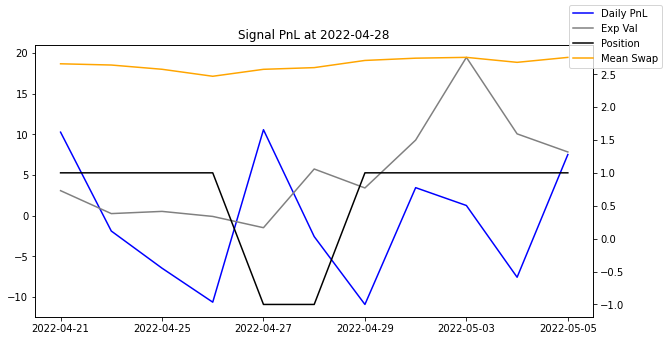

,pnl,mean_swap,position,exp_val
2022-05-20,-0.05009,2.52983,1,5.307967
2022-05-23,0.05648,2.58631,1,7.695054
2022-05-24,-0.10800,2.47831,1,4.499782
2022-05-25,-0.00485,2.47346,1,5.337023
2022-05-26,0.01000,2.48346,1,-0.746280
2022-05-27,0.00697,2.49043,-1,5.347120
2022-05-30,-0.00002,2.49045,1,7.398284
2022-05-31,0.08958,2.58003,1,10.295527
2022-06-01,0.07678,2.65681,1,6.198352
2022-06-02,0.00658,2.66339,1,11.352957


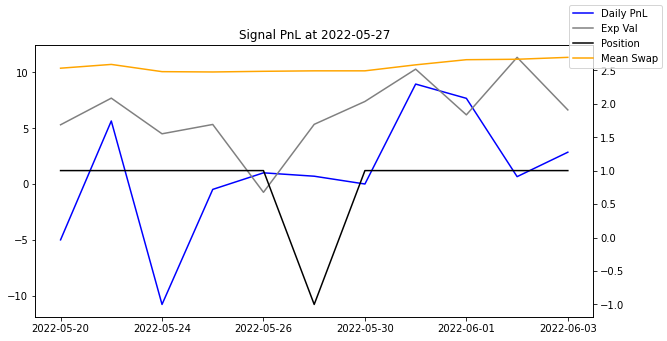

,pnl,mean_swap,position,exp_val
2022-06-10,0.18549,2.99937,1,10.974319
2022-06-13,0.25048,3.24985,1,20.671028
2022-06-14,0.08884,3.33869,1,9.349077
2022-06-15,-0.20910,3.12959,1,4.530647
2022-06-16,-0.07394,3.05565,1,-2.984454
2022-06-17,0.05515,3.11080,-1,7.185208
2022-06-20,-0.00974,3.12054,1,0.960761
2022-06-21,0.01802,3.13856,1,1.442416
2022-06-22,-0.13145,3.00711,1,8.491379
2022-06-23,-0.07606,2.93105,1,5.192505


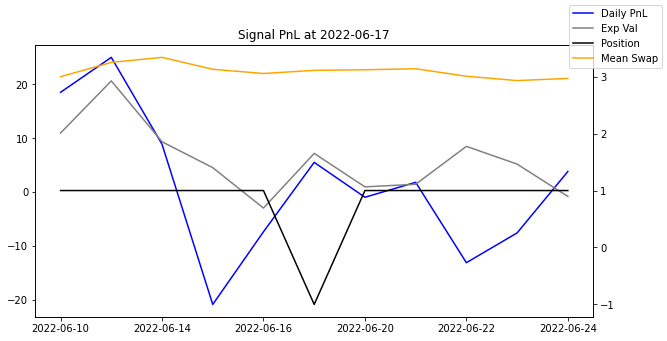

,pnl,mean_swap,position,exp_val
2022-06-20,-0.00974,3.12054,1,0.960761
2022-06-21,0.01802,3.13856,1,1.442416
2022-06-22,-0.13145,3.00711,1,8.491379
2022-06-23,-0.07606,2.93105,1,5.192505
2022-06-24,0.03810,2.96915,1,-0.822617
2022-06-27,0.05757,3.02672,-1,-2.175269
2022-06-28,0.01626,3.01046,-1,5.455327
2022-06-29,0.07183,2.93863,1,-3.621882
2022-06-30,-0.09621,2.84242,-1,7.560011
2022-07-01,0.14724,2.69518,1,14.550637


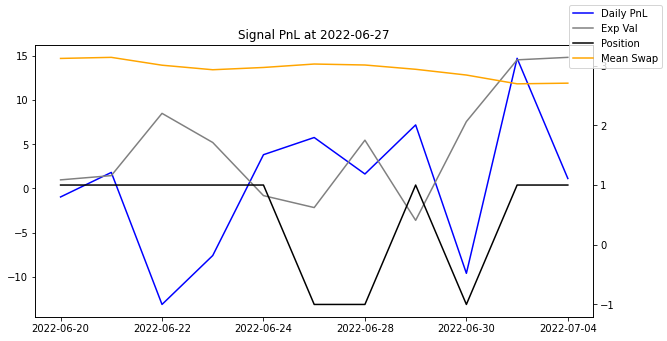

,pnl,mean_swap,position,exp_val
2022-06-21,0.01802,3.13856,1,1.442416
2022-06-22,-0.13145,3.00711,1,8.491379
2022-06-23,-0.07606,2.93105,1,5.192505
2022-06-24,0.03810,2.96915,1,-0.822617
2022-06-27,0.05757,3.02672,-1,-2.175269
2022-06-28,0.01626,3.01046,-1,5.455327
2022-06-29,0.07183,2.93863,1,-3.621882
2022-06-30,-0.09621,2.84242,-1,7.560011
2022-07-01,0.14724,2.69518,1,14.550637
2022-07-04,0.01115,2.70633,1,14.832692


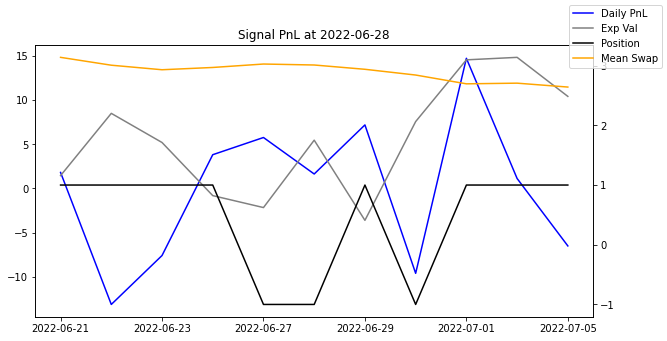

,pnl,mean_swap,position,exp_val
2022-06-23,-0.07606,2.93105,1,5.192505
2022-06-24,0.03810,2.96915,1,-0.822617
2022-06-27,0.05757,3.02672,-1,-2.175269
2022-06-28,0.01626,3.01046,-1,5.455327
2022-06-29,0.07183,2.93863,1,-3.621882
2022-06-30,-0.09621,2.84242,-1,7.560011
2022-07-01,0.14724,2.69518,1,14.550637
2022-07-04,0.01115,2.70633,1,14.832692
2022-07-05,-0.06518,2.64115,1,10.412682
2022-07-06,0.14873,2.78988,1,4.242454


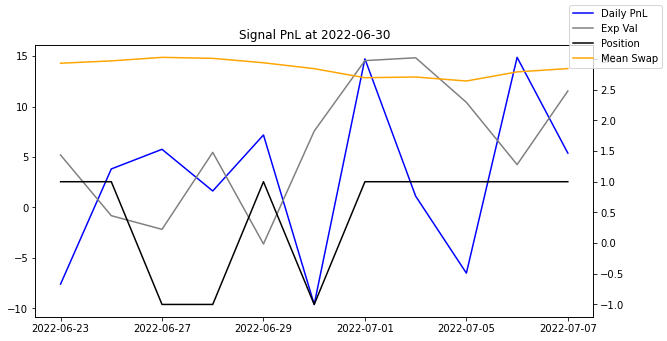

In [1865]:
for i in rec_prob_df[rec_prob_df.position == -1].index:
    date = list(rec_prob_df.index).index(i)
    date_fwd = list(rec_prob_df.index)[date+5]
    date_bwd = list(rec_prob_df.index)[date-5]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    display(rec_prob_df.loc[date_bwd:date_fwd, 
                ['pnl', 'mean_swap', 'position', 'exp_val']])
    
    plt.plot(rec_prob_df.loc[date_bwd:date_fwd, 'pnl']*100, color='blue', label='Daily PnL')
    plt.plot(rec_prob_df.loc[date_bwd:date_fwd, 'exp_val'], color='grey', label='Exp Val')
    
    ax2 = ax.twinx()
    ax2.plot(rec_prob_df.loc[date_bwd:date_fwd, 'position'], color='black', label='Position')
    ax2.plot(rec_prob_df.loc[date_bwd:date_fwd, 'mean_swap'], color='orange', label='Mean Swap')


    fig.legend()
    ax.xaxis.set_major_locator(dates.DayLocator(interval=2))

    plt.title(f'Signal PnL at {i}')
    plt.show()

# Results

In [1795]:
rec_prob_df.index = pd.to_datetime(rec_prob_df.index)

In [1796]:
rec_prob_df_month = rec_prob_df.resample('M').mean()
rec_prob_df_month_std = rec_prob_df.resample('M').std()
rec_prob_df_month['time'] = rec_prob_df_month.index

In [1908]:
rec_prob_df_month[['pnl']]

,pnl
2021-11-30,-0.032880
2021-12-31,0.080452
2022-01-31,0.188303
2022-02-28,0.068299
2022-03-31,0.355205
2022-04-30,0.152754
2022-05-31,-0.069747
2022-06-30,0.228595
2022-07-31,-0.000406
2022-08-31,0.261360


In [1907]:
rec_prob_df_month_std[['pnl']]

,pnl
2021-11-30,0.164449
2021-12-31,0.117357
2022-01-31,0.158898
2022-02-28,0.232051
2022-03-31,0.275474
2022-04-30,0.265297
2022-05-31,0.224846
2022-06-30,0.348432
2022-07-31,0.287125
2022-08-31,0.289670


In [1909]:
rec_prob_df_month[['pnl']] / rec_prob_df_month_std[['pnl']]

,pnl
2021-11-30,-0.057718
2021-12-31,0.197897
2022-01-31,0.342095
2022-02-28,0.084965
2022-03-31,0.372228
2022-04-30,0.166215
2022-05-31,-0.089547
2022-06-30,0.189390
2022-07-31,-0.000408
2022-08-31,0.260462


In [1899]:
print(f'Mean Daily PnL is {round(rec_prob_df["pnl"].mean(), 4)}')

Mean Monthly PnL is 0.0102


In [1903]:
print(f'Mean Annual PnL is {round(rec_prob_df["pnl"].mean() * 252, 4)}')

Mean Annual PnL is 2.5805


In [1902]:
print(f'Std Daily PnL is {round(rec_prob_df["pnl"].std(), 4)}')

Std Daily PnL is 0.0701


In [1904]:
print(f'Std Annual PnL is {round(rec_prob_df["pnl"].std() * np.sqrt(252), 4)}')

Std Annual PnL is 1.1126


In [1905]:
print(f'Sharpe Ratio is {round(rec_prob_df["pnl"].mean()*252/ rec_prob_df["pnl"].std(), 2) / np.sqrt(252)}')

Sharpe Ratio is 2.3194419826999577
